In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
sns.set_style('whitegrid')

In [3]:
import category_encoders as ce

In [4]:
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth

In [5]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [6]:
import tensorflow as tf

In [7]:
import keras
from keras.models import Model
import kerastuner

In [8]:
from keras.layers import Dense, Input, Dropout

## Keras notebook with clustering added
In this notebook, do PCA on `g-` and `c-` features separately.
1. Plot PCA explained variance, pick a number of PCA dimensions to pass to NN.
1. Visualize 2D PCA of this dataset.
1. Select an optimal Mean Shift bandwidth and number of PCA dimensions to cluster on, then cluster.
1. Make cluster id a categorical feature, hot encode it.
1. Pass `cp` features, PCA dimensions and cluster id to three layer NN.
1. Tune the network & train up the best candidate.

In [9]:
tf_df = pd.read_csv('../input/lish-moa/train_features.csv',index_col='sig_id')
tts_df = pd.read_csv('../input/lish-moa/train_targets_scored.csv',index_col='sig_id')
tf_df['cp_type']=tf_df['cp_type'].astype('category')
scaler = MinMaxScaler(feature_range=(-0.5,0.5))
tf_df['cp_time']=scaler.fit_transform((np.array(tf_df['cp_time'])).reshape(-1,1))
tf_df['cp_dose']=tf_df['cp_dose'].astype('category')
# transformer = StandardScaler()
# tf_df.loc[:,'g-0':'c-99']=transformer.fit_transform(tf_df.loc[:,'g-0':'c-99'])

In [10]:
oenc = ce.ordinal.OrdinalEncoder()
tf_df = oenc.fit_transform(tf_df)
tf_df.sample(5)

cp_type  cp_time  cp_dose     g-0     g-1     g-2     g-3  \
sig_id                                                                    
id_d2c029a56        1      0.0        1 -0.1936 -0.1543 -0.7847  1.0640   
id_1fd9f102c        1     -0.5        2  3.9020  1.3090  0.8707  4.0490   
id_3e46c41d4        1      0.0        1  1.0980 -0.9050  3.3910  0.2880   
id_4734fd72d        1      0.5        1 -2.0670  0.6014 -0.0956  0.8437   
id_9e825c5c9        1      0.5        2  0.7428 -0.6585  0.2741 -0.3392   

                 g-4     g-5     g-6  ...    c-90    c-91    c-92    c-93  \
sig_id                                ...                                   
id_d2c029a56  1.7530 -0.2600 -0.3452  ...  1.1410  0.2534  1.4930  1.0520   
id_1fd9f102c  1.1010  1.0240  1.9650  ... -8.8940 -8.8000 -6.6770 -9.6680   
id_3e46c41d4 -0.1686  1.9060  0.7604  ... -0.3701  0.8984 -0.4072  0.4321   
id_4734fd72d  0.7436 -0.2362  0.4384  ...  0.7703  0.3020  0.6574  0.6470   
id_9e825c5c9 -0.1202  0.1111 -0.3820  ... -0.2035 -0.0791  0.9551 -1.0700   

                c-94    c-95    c-96    c-97    c-98    c-99  
sig_id                                                        
id_d2c029a56 -0.1138  0.0416 -0.4919 -0.2453 -0.5183  0.0814  
id_1fd9f102c -6.7830 -2.7340 -8.1610 -5.9100 -5.1570 -3.2460  
id_3e46c41d4  0.3438  0.0001  0.1237  0.0959  0.7769  1.1580  
id_4734fd72d  0.6315  0.1293 -0.3042  0.7613  0.8546  0.8126  
id_9e825c5c9  0.6962 -1.0100  0.1489  0.3483 -0.7736 -2.3430  

[5 rows x 875 columns]

In [11]:
tf_df['cp_type']=tf_df['cp_type']-1
tf_df['cp_dose']=tf_df['cp_dose']-1
tf_df.head()

cp_type  cp_time  cp_dose     g-0     g-1     g-2     g-3  \
sig_id                                                                    
id_000644bb2        0     -0.5        0  1.0620  0.5577 -0.2479 -0.6208   
id_000779bfc        0      0.5        0  0.0743  0.4087  0.2991  0.0604   
id_000a6266a        0      0.0        0  0.6280  0.5817  1.5540 -0.0764   
id_0015fd391        0      0.0        0 -0.5138 -0.2491 -0.2656  0.5288   
id_001626bd3        0      0.5        1 -0.3254 -0.4009  0.9700  0.6919   

                 g-4     g-5     g-6  ...    c-90    c-91    c-92    c-93  \
sig_id                                ...                                   
id_000644bb2 -0.1944 -1.0120 -1.0220  ...  0.2862  0.2584  0.8076  0.5523   
id_000779bfc  1.0190  0.5207  0.2341  ... -0.4265  0.7543  0.4708  0.0230   
id_000a6266a -0.0323  1.2390  0.1715  ... -0.7250 -0.6297  0.6103  0.0223   
id_0015fd391  4.0620 -0.8095 -1.9590  ... -2.0990 -0.6441 -5.6300 -1.3780   
id_001626bd3  1.4180 -0.8244 -0.2800  ...  0.0042  0.0048  0.6670  1.0690   

                c-94    c-95    c-96    c-97    c-98    c-99  
sig_id                                                        
id_000644bb2 -0.1912  0.6584 -0.3981  0.2139  0.3801  0.4176  
id_000779bfc  0.2957  0.4899  0.1522  0.1241  0.6077  0.7371  
id_000a6266a -1.3240 -0.3174 -0.6417 -0.2187 -1.4080  0.6931  
id_0015fd391 -0.8632 -1.2880 -1.6210 -0.8784 -0.3876 -0.8154  
id_001626bd3  0.5523 -0.3031  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 875 columns]

1. Plot PCA explained variance for `g-` and `c-` features.

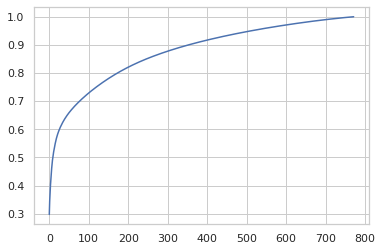

In [12]:
pca_g = PCA()
g_pca_df = pd.DataFrame(pca_g.fit_transform(tf_df.loc[:,'g-0':'g-771']),index=tf_df.index)
g_var_explain = np.cumsum(pca_g.explained_variance_ratio_)
plt.plot(g_var_explain)
plt.show()

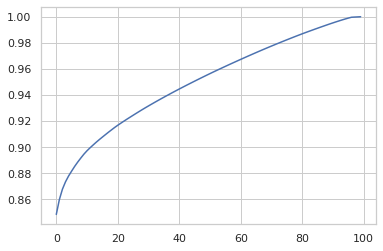

In [13]:
pca_c = PCA()
c_pca_df = pd.DataFrame(pca_c.fit_transform(tf_df.loc[:,'c-0':'c-99']),index=tf_df.index)
c_var_explain = np.cumsum(pca_c.explained_variance_ratio_)
plt.plot(c_var_explain)
plt.show()

1. Pick a number of PCA dimension to pass as NN inputs:

In [14]:
g_var_explain[g_var_explain<0.6]

array([0.29734508, 0.34410798, 0.3745819 , 0.40162744, 0.42326748,
       0.44320877, 0.46072195, 0.47737419, 0.48957602, 0.50039008,
       0.51033589, 0.51953365, 0.52730413, 0.53490378, 0.54224014,
       0.54930426, 0.5556887 , 0.56180496, 0.56751932, 0.57271804,
       0.57760574, 0.58201959, 0.58627179, 0.59023977, 0.59400926,
       0.59756794])

In [15]:
c_var_explain[c_var_explain<0.86]

array([0.84853809, 0.85991709])

Ok, THAT'S interesting. Straight-no-chaser, as-provided `c-` variation is concentrated in that first PCA dimension, which I'm strongly suspecting is basically "SCREECH KILL KILL" (or if I'm being less cryptic, the primary effect of drugs on the cell viability, if there is any, is broad spectrum toxicity). Let's check the components; I did that once...

In [16]:
pca_c.components_[0,:]

array([-0.08971376, -0.10644446, -0.11072059, -0.07823494, -0.11310322,
       -0.10078192, -0.11997049, -0.0726784 , -0.10468699, -0.08259113,
       -0.11140378, -0.11101845, -0.11329532, -0.1179659 , -0.08060507,
       -0.1056513 , -0.07695712, -0.11049436, -0.12126021, -0.08234373,
       -0.1041336 , -0.10733322, -0.0788044 , -0.07823044, -0.10512867,
       -0.09914511, -0.12150564, -0.10145941, -0.09999348, -0.07524781,
       -0.08984445, -0.10738283, -0.09064616, -0.11790382, -0.10448263,
       -0.09047495, -0.1037094 , -0.06094476, -0.12372822, -0.09656622,
       -0.10769672, -0.10616105, -0.11130871, -0.10373436, -0.10298574,
       -0.11192068, -0.09156892, -0.09876522, -0.10558409, -0.08858353,
       -0.09176933, -0.10584508, -0.10875898, -0.09057859, -0.09879073,
       -0.11409073, -0.07302758, -0.1012047 , -0.05850324, -0.11428751,
       -0.11385208, -0.08748818, -0.10217313, -0.1230526 , -0.09170258,
       -0.11661172, -0.10732093, -0.10915382, -0.09788615, -0.07

SCREECH KILL KILL (I believe that was Shining Force I, by the way)

In [17]:
pca_c.components_[1,:]

array([ 0.1101463 , -0.06771955, -0.03404396, -0.00180231, -0.07534766,
       -0.06441954, -0.07374153,  0.11120286, -0.01567694, -0.07525599,
        0.01619381, -0.05184685,  0.02176484, -0.02443001,  0.10515687,
        0.03016075,  0.21255264,  0.12691543, -0.2747343 ,  0.06549926,
        0.16814088, -0.048238  , -0.24909016,  0.02744452, -0.03689499,
       -0.04011473, -0.15472372,  0.13227548, -0.06714169,  0.13011023,
        0.08051755,  0.06047939,  0.17896899,  0.02799002, -0.01910719,
        0.13953236, -0.11916257,  0.06113058, -0.13932054,  0.10348494,
       -0.06301378, -0.03557659, -0.02379655, -0.05974368,  0.13835461,
        0.06887495, -0.02225931, -0.03415981, -0.23159697, -0.12171719,
       -0.14988872,  0.01280294, -0.04208199,  0.17699338, -0.00565648,
       -0.07420319,  0.08754961, -0.1032785 ,  0.0428991 ,  0.04517922,
        0.03143235,  0.16497721, -0.01536609, -0.15141172, -0.05098021,
       -0.04689361, -0.0317495 , -0.10117603,  0.13451299,  0.06

Note that the coefficients are now not all negative; this component picks winner cell types and loser cell types.

2. Visualize 2D PCA of this dataset.

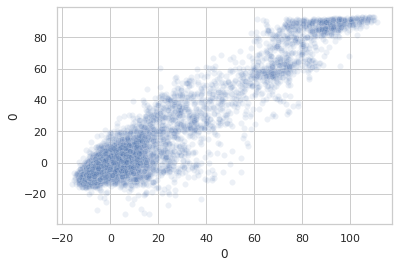

In [18]:
sns.scatterplot(x=g_pca_df[0],y=c_pca_df[0],alpha=0.1)

This breakdown doesn't look as friendly for clustering until I turn alpha down. Meanwhile, why do the first genetic activation component and the SCREECH KILL KILL component covary so strongly?

In [19]:
pca_g.components_[0,:]

array([ 5.53246127e-02, -1.58525631e-04,  1.05175076e-02,  7.15220862e-03,
        2.30255984e-02, -1.17511714e-02,  6.25641099e-03, -3.92960995e-02,
       -6.41859684e-02, -3.08449114e-02, -5.04009907e-02,  2.12190636e-02,
       -2.31165221e-02,  4.18796917e-02, -3.29443674e-02, -3.36047759e-03,
       -4.73824237e-02, -3.58621456e-02,  4.38583492e-03, -1.60226674e-03,
       -3.29427921e-02, -6.46195994e-03,  1.72477018e-04, -8.75743732e-03,
       -3.38128983e-02, -1.40356687e-02, -3.54874353e-02,  8.37797509e-03,
       -3.42583031e-02, -2.78724799e-02, -5.39863771e-02,  6.37238017e-02,
       -1.85259882e-02,  9.61765028e-04, -9.34873276e-03,  1.79990478e-02,
       -2.81570516e-02, -1.02034313e-01,  9.32322594e-02,  3.45450114e-02,
       -4.03076474e-02, -4.12312078e-02, -1.39338630e-02, -4.17086512e-03,
       -2.81784660e-04, -1.37378255e-02,  4.12157765e-02,  2.81731328e-03,
        2.50406539e-02,  2.26993564e-02, -1.03553851e-01,  2.43090148e-02,
       -2.23072603e-02,  

Nothing obvious. I wondered if it was a global TURN DEM GENES OFF signal, but no, certainly not.

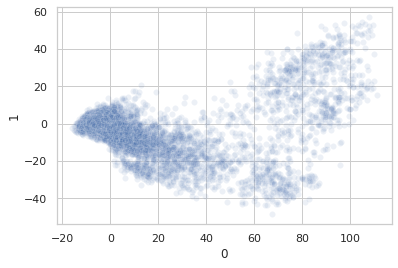

In [20]:
sns.scatterplot(x=g_pca_df[0],y=g_pca_df[1],alpha=0.1)

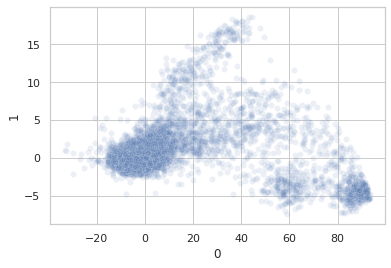

In [21]:
sns.scatterplot(x=c_pca_df[0],y=c_pca_df[1],alpha=0.1)

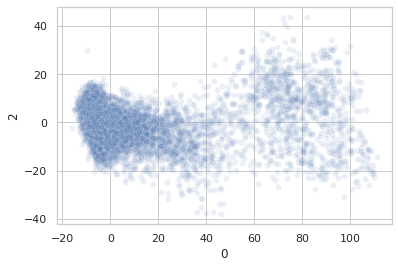

In [22]:
sns.scatterplot(x=g_pca_df[0],y=g_pca_df[2],alpha=0.1)

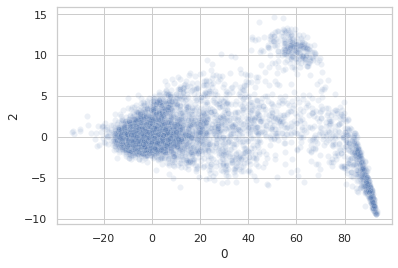

In [23]:
sns.scatterplot(x=c_pca_df[0],y=c_pca_df[2],alpha=0.1)

In [24]:
top_ten_df = pd.concat([g_pca_df.loc[:,0:6],c_pca_df.loc[:,0:2]],axis=1)
top_ten_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23814 entries, id_000644bb2 to id_ffffdd77b
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       23814 non-null  float64
 1   1       23814 non-null  float64
 2   2       23814 non-null  float64
 3   3       23814 non-null  float64
 4   4       23814 non-null  float64
 5   5       23814 non-null  float64
 6   6       23814 non-null  float64
 7   0       23814 non-null  float64
 8   1       23814 non-null  float64
 9   2       23814 non-null  float64
dtypes: float64(10)
memory usage: 2.0+ MB


In [25]:
top_ten_df.columns = ['g0','g1','g2','g3','g4','g5','g6','c0','c1','c2']

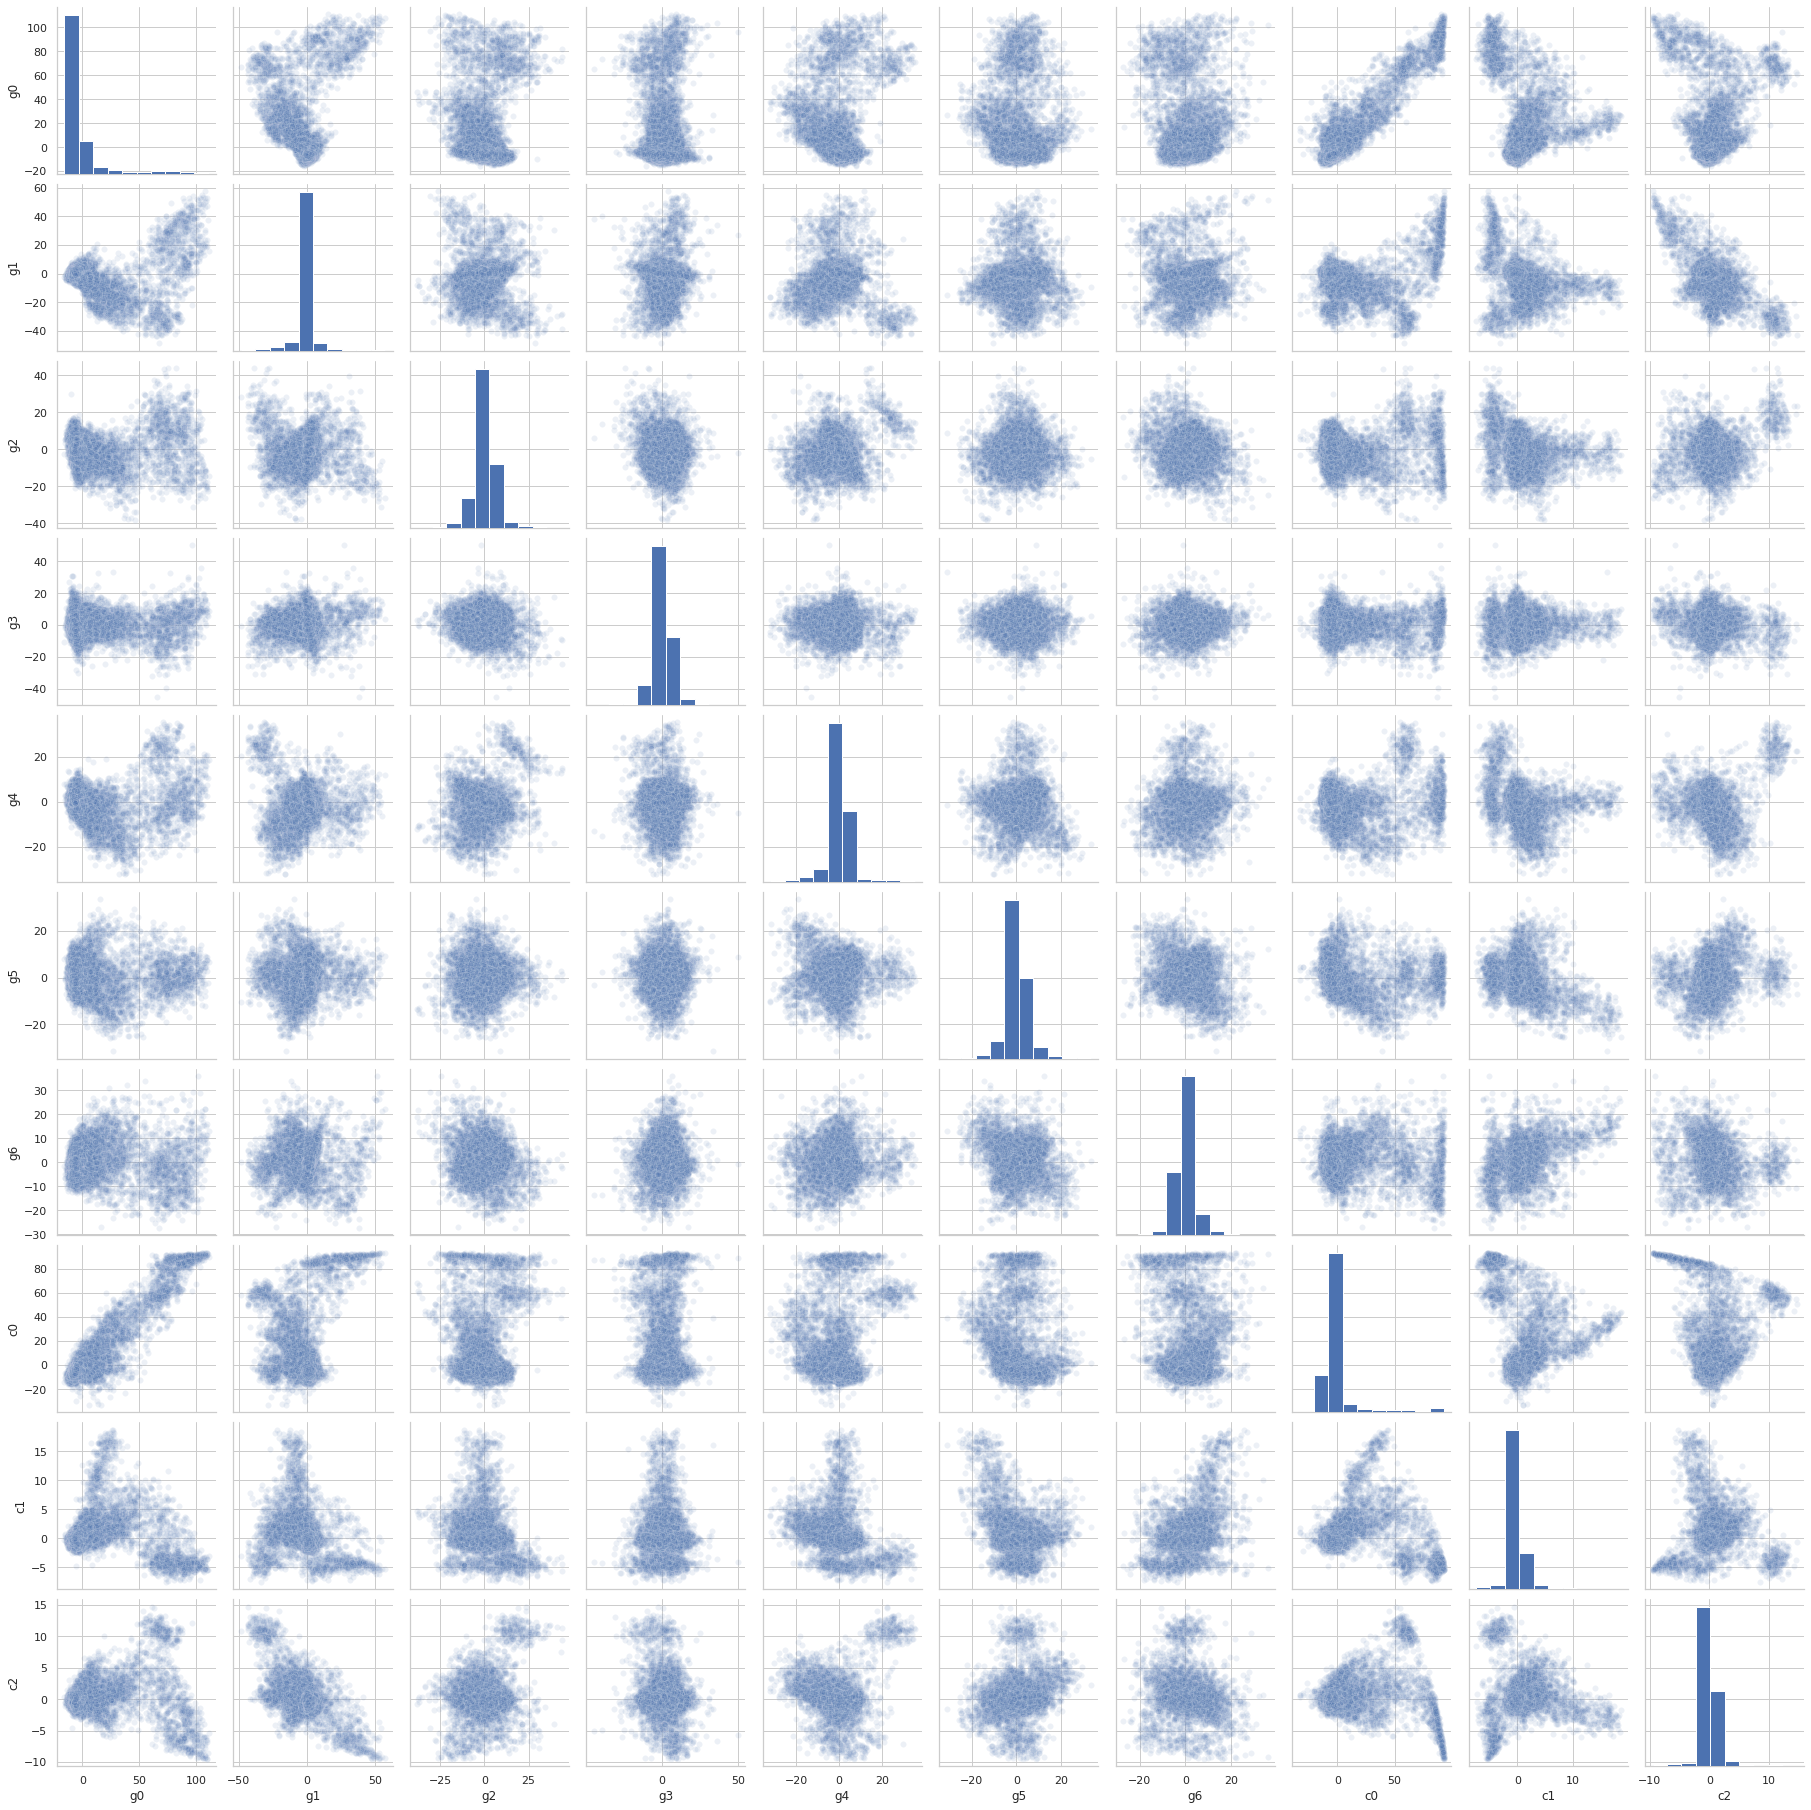

In [26]:
sns.pairplot(top_ten_df,plot_kws=dict(alpha=0.1))

My hunch, looking at that graph, is that the six best dimensions for clustering are the first three `g` and three `c` dimensions (not to be confused with the original `g-0` to `g-2` and `c-0` to `c-2`).

In the original clustering notebook I checked the total range of the first several PCA columns and then shrank them to be proportional to the amount of variation those dimensions explained. I didn't have any theoretical justification for this; it just sounded reasonable.

Here I will at least look at the six dimensions I have chosen and what their ranges are. I may simply go ahead and cluster after stretching them to have consistent ranges, or I may squint at the pairplot and decide which ones to stretch relative to others.

I'm going to put the `c` dimensions in front because I suspect they will cluster better.

In [27]:
top_six_df = pd.concat([c_pca_df.loc[:,0:2],g_pca_df.loc[:,0:2]],axis=1)
top_six_df.columns = ['c0','c1','c2','g0','g1','g2']
ranges = top_six_df.max()-top_six_df.min()
ranges

c0    126.274358
c1     26.116123
c2     24.195421
g0    126.771720
g1    105.892402
g2     82.084268
dtype: float64

In [28]:
t6scaler = MinMaxScaler()
cluster_df = pd.DataFrame(t6scaler.fit_transform(top_six_df),
                          index=top_six_df.index,
                          columns=top_six_df.columns)
cluster_df.head()

c0        c1        c2        g0        g1        g2
sig_id                                                                  
id_000644bb2  0.203641  0.308912  0.392035  0.060027  0.454355  0.416942
id_000779bfc  0.202553  0.257087  0.396663  0.073002  0.490896  0.578668
id_000a6266a  0.243526  0.294398  0.396881  0.111641  0.480585  0.458304
id_0015fd391  0.371792  0.566739  0.400866  0.198017  0.413769  0.450402
id_001626bd3  0.211369  0.295778  0.403855  0.067992  0.461327  0.568124

3. Conduct silhouette tests of the data reduced to various PCA dimensions, up to 6.

Previously I found MeanShift seemed far and away better than KMeans or DBSCAN.

I also found that the silhouette scores did in fact go down if I fed the algorithms the raw PCA output rather than my questionably rescaled values, so questionably rescaled values it is.

I can take some steps to speed up MeanShift by
1. calculating `estimate_bandwidth` ahead of time in an optimized fashion, using less than all the points
1. using bin seeding with a cutoff number of points for bins
1. setting n_jobs=2

Let me deliberately plan out how I will gridsearch, save models, and plot the metrics for each hyperparameter choice in [ #dims, bandwidth ]. I recalculate the bandwidth at different quantiles.

In [29]:
bw30 = []
for dim in range(6):
    # quantile = 0.3 is the default
    bw30.append(estimate_bandwidth(cluster_df.iloc[:,0:dim+1],quantile=0.3,n_samples=1000,n_jobs=2))
    print(f'Bandwidth for {dim+1} dimensions is {bw30[dim]}\n')

Bandwidth for 1 dimensions is 0.051835677942629194

Bandwidth for 2 dimensions is 0.07420975650688903

Bandwidth for 3 dimensions is 0.09101919502095929

Bandwidth for 4 dimensions is 0.11452954572576132

Bandwidth for 5 dimensions is 0.12398050757559645

Bandwidth for 6 dimensions is 0.1457124733640805



In [30]:
bw50 = []
for dim in range(1,7):
    bw50.append(estimate_bandwidth(cluster_df.iloc[:,0:dim],quantile=0.5,n_samples=1000,n_jobs=2))
    print(f'Bandwidth for {dim} dimensions is {bw50[-1]}\n')

Bandwidth for 1 dimensions is 0.0634168278776201

Bandwidth for 2 dimensions is 0.08648259811023568

Bandwidth for 3 dimensions is 0.10395928375792295

Bandwidth for 4 dimensions is 0.1277638989187781

Bandwidth for 5 dimensions is 0.1369282536501804

Bandwidth for 6 dimensions is 0.1634302712442104



In [31]:
bw80 = []
for dim in range(1,7):
    # quantile = 0.3 is the default
    bw80.append(estimate_bandwidth(cluster_df.iloc[:,0:dim],quantile=0.8,n_samples=1000,n_jobs=2))
    print(f'Bandwidth for {dim} dimensions is {bw80[-1]}\n')

Bandwidth for 1 dimensions is 0.08952996755284677

Bandwidth for 2 dimensions is 0.11317044961473555

Bandwidth for 3 dimensions is 0.131650636632135

Bandwidth for 4 dimensions is 0.15938660159758927

Bandwidth for 5 dimensions is 0.16986877742779086

Bandwidth for 6 dimensions is 0.21486090644285538



I want
* a plot of silhouette scores per number of PCA dimensions clustered
* a different color and legend entry for each bandwidth quantile
* I will need to fit a MeanShift model at each of these combinations
    * save the model
        * perhaps in a two-layer dictionary with bw -> #dims
    * save the silhouette score
        * preferably in a dataframe with column labels `bw30, bw50, bw80`

In [32]:
ms_models = {}
ms_sils = {}
bws = ['bw30','bw50','bw80']
for i, bwq in enumerate([bw30, bw50, bw80]):
    bw_lbl = bws[i]
    ms_models[bw_lbl]={}
    ms_sils[bw_lbl]=[]
    for dim in range(1,7):
        data = cluster_df.iloc[:,0:dim].copy()
        ms_models[bw_lbl][dim]=MeanShift(bandwidth=bwq[dim-1],
                                    bin_seeding=True,
                                    min_bin_freq=10,
                                    n_jobs=2).fit(data)
        labels = ms_models[bw_lbl][dim].labels_
        ms_sils[bw_lbl].append(metrics.silhouette_score(data,labels))
mssil_df = pd.DataFrame(ms_sils,index=range(1,7))

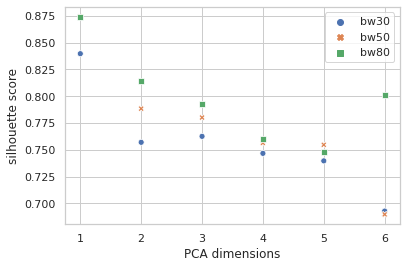

In [33]:
plt.xlabel('PCA dimensions')
plt.ylabel('silhouette score')
sns.scatterplot(data=mssil_df)
plt.show()

I should really store the number of clusters for each model; that's interesting, too. For a given silhouette score, more clusters presumably means more data for the neural net to use.

In [34]:
ms_clusts = {}
for bw_lbl in bws:
    ms_clusts[bw_lbl] = []
    for dim in range(1,7):
        ms_clusts[bw_lbl].append(len(ms_models[bw_lbl][dim].cluster_centers_))
msclusts_df = pd.DataFrame(ms_clusts,index=range(1,7))

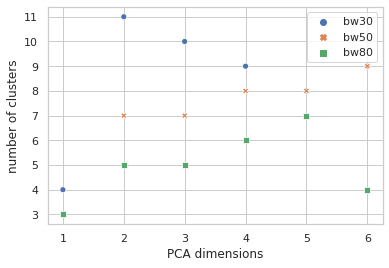

In [35]:
plt.xlabel('PCA dimensions')
plt.ylabel('number of clusters')
sns.scatterplot(data=msclusts_df)
plt.show()

3. I will gladly take that silhouette score hit to get eleven clusters. 30% bandwidth and 2 PCA dimensions it is.

I wonder how many points are orphaned?

In [36]:
labels = pd.Series(ms_models['bw30'][2].labels_)
labels[labels==-1].count()

0

Still none. Excellent.

In [37]:
labels.value_counts()

0     21739
1       473
3       362
5       350
2       237
4       137
7       126
6       119
9       112
8        82
10       77
dtype: int64

4. Hot encode the cluster labels. Definitely want to drop a feature so that these columns are not mutually collinear, and it seems reasonable to drop cluster 0 and regard the small clusters as 'flavor' (or is that 'flava').

In [38]:
ohenc = OneHotEncoder(drop='first',sparse=False,dtype=np.int)
cats = ohenc.fit_transform(np.array(labels).reshape(-1,1))
cats[:5,:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

5. Pass `cp` features, PCA dimensions and cluster id to three layer NN.
6. Tune the network & train up the best candidate.

So the question now is how many PCA dimensions to pass to the model. I'm going to stack together an input array from `cp` features (3 columns), cluster encoding (10 columns for 11 clusters), `g-` dimensions and `c-` dimensions. I really want the tuner to *tell* me how many of each type of dimensions to pass. So let's think about our previous results.

* My three tuner models with scores below 0.03:
    * elu, elu, elu, softmax!, 0.35, 0.2, 0.2, lr 0.001, 256, 32, 256
    * 128, elu, 0.35, 512, relu, 0.2, 128, elu, 0.5, lr 0.001
    * 512, relu, 0.35, 512, relu, 0.5, 512, relu, 0.2, lr 0.001

There's less help here than I thought. Law of Small Numbers tells me to use a learning rate of 0.001 (and I probably will) and a palindromic model with inversion symmetry (!)... aside from the dropout rate... forget it. I might want to increase the number of layers, but let's not get too far ahead of myself. Aside from leaving learning rate at the default, I'll keep the existing tuner options. If I have another model that pegs at 512 I might rerun it with 1024 and 2048 options. (That'll stay busy in the background while I work on my local.)

I am willing to give the tuner one additional degree of freedom. I got an ok model with 30 PCA dimensions and a more ok model with 83, so let's have these as options:
* `g-`: 20, 60, 180
* `c-`: 5, 15, 45

Well. After some searching, I don't think there is a way to have `kerastuner` itself handle the dimension switching, so I'm going to throw more resources at it and trust the neural network to vote against the less important inputs.

There are two ways I'd like to go:
* `g-`: 175 components, `c-`: 25, approximately the same number of inputs as outputs
* throw the scaled original features in along with the clusters; that can be another notebook

Speaking of another notebook, at some point I should implement the "if it's a control experiment, predict 0" circuit breaker. That may or may not be contrary to the spirit of the thing in terms of creating a tool for actual use, but it would be instructive.

In [40]:
pca_df = pd.concat([g_pca_df.loc[:,0:174],c_pca_df.loc[:,0:24]],axis=1)
pca_scaler = StandardScaler()
pca_sc = pca_scaler.fit_transform(pca_df)
print(cats.shape,pca_sc.shape)

(23814, 10) (23814, 200)


In [41]:
cps = np.array(tf_df.loc[:,'cp_type':'cp_dose'])
tf_arr = np.concatenate((cps,cats,pca_sc),axis=1)
tf_arr.shape

(23814, 213)

In [42]:
tts_arr = np.array(tts_df)
tts_arr.shape

(23814, 206)

Get crackalackin'.

In [43]:
strategy = tf.distribute.get_strategy()
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  1


Now let's tune.

In [44]:
def build_model(hp):
    inputs = Input(shape=(213,))
    x = Dense(
        units = hp.Choice('units 1',values=[32,128,512]),
        activation = hp.Choice('activation function 1',values=['relu','elu'])
    )(inputs)
    x = Dropout(hp.Choice('dropout 1',values=[0.2,0.35,0.5]))(x)
    x = Dense(
        units = hp.Choice('units 2',values=[32,128,512]),
        activation = hp.Choice('activation function 2',values=['relu','elu'])
    )(x)
    x = Dropout(hp.Choice('dropout 2',values=[0.2,0.35,0.5]))(x)
    x = Dense(
        units = hp.Choice('units 3',values=[32,128,512]),
        activation = hp.Choice('activation function 3',values=['relu','elu'])
    )(x)
    x = Dropout(hp.Choice('dropout 3',values=[0.2,0.35,0.5]))(x)

    outputs = Dense(206,activation = 'sigmoid')(x)
    model = Model(inputs, outputs)
    # should throw in a choice of optimizer here: adam, etc.
    model.compile(optimizer='adam',loss='binary_crossentropy',
                  metrics=['binary_crossentropy','accuracy'])
    return model

In [45]:
with strategy.scope():
    tuner = kerastuner.tuners.Hyperband(
            build_model,
            objective='binary_crossentropy',
            max_epochs=18,
            executions_per_trial=2,
            directory='keras_tune'
    )

In [46]:
print('Starting Tuning')
X_train, X_val, y_train, y_val = train_test_split(tf_arr,tts_arr,test_size=0.2,random_state=84)
tuner.search(X_train,y_train,validation_data=(X_val,y_val))
print('Finished Tuning')

Starting Tuning
Epoch 1/2
596/596 [==============================] - ETA: 0s - loss: 0.7500 - binary_crossentropy: 0.7500 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.6165 - binary_crossentropy: 0.6165 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.4969 - binary_crossentropy: 0.4969 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.3747 - binary_crossentropy: 0.3747 - accuracy: 6.7935e- - ETA: 1s - loss: 0.2992 - binary_crossentropy: 0.2992 - accuracy: 5.1230e- - ETA: 1s - loss: 0.2529 - binary_crossentropy: 0.2529 - accuracy: 0.0012   - ETA: 1s - loss: 0.2200 - binary_crossentropy: 0.2200 - accuracy: 0.00 - ETA: 1s - loss: 0.1968 - binary_crossentropy: 0.1968 - accuracy: 0.00 - ETA: 1s - loss: 0.1765 - binary_crossentropy: 0.1765 - accuracy: 0.00 - ETA: 1s - loss: 0.1613 - binary_crossentropy: 0.1613 - accuracy: 0.00 - ETA: 1s - loss: 0.1488 - binary_crossentropy: 0.1488 - accuracy: 0.00 - ETA: 1s - loss: 0.1384 - binary_crossentropy: 0.1384 - accuracy: 0.00 - ETA: 1s - loss: 0.1300 - binary_crossentrop

Epoch 1/2
596/596 [==============================] - ETA: 0s - loss: 0.7170 - binary_crossentropy: 0.7170 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.5062 - binary_crossentropy: 0.5062 - accuracy: 0.0024   - ETA: 1s - loss: 0.3563 - binary_crossentropy: 0.3563 - accuracy: 0.00 - ETA: 1s - loss: 0.2604 - binary_crossentropy: 0.2604 - accuracy: 0.00 - ETA: 1s - loss: 0.2067 - binary_crossentropy: 0.2067 - accuracy: 0.00 - ETA: 1s - loss: 0.1714 - binary_crossentropy: 0.1714 - accuracy: 0.00 - ETA: 1s - loss: 0.1487 - binary_crossentropy: 0.1487 - accuracy: 0.00 - ETA: 1s - loss: 0.1327 - binary_crossentropy: 0.1327 - accuracy: 0.00 - ETA: 1s - loss: 0.1203 - binary_crossentropy: 0.1203 - accuracy: 0.01 - ETA: 1s - loss: 0.1106 - binary_crossentropy: 0.1106 - accuracy: 0.01 - ETA: 1s - loss: 0.1032 - binary_crossentropy: 0.1032 - accuracy: 0.01 - ETA: 0s - loss: 0.0966 - binary_crossentropy: 0.0966 - accuracy: 0.01 - ETA: 0s - loss: 0.0913 - binary_crossentropy: 0.0913 - accuracy: 0.01 - ETA

Epoch 1/2
596/596 [==============================] - ETA: 0s - loss: 0.7685 - binary_crossentropy: 0.7685 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.4164 - binary_crossentropy: 0.4164 - accuracy: 0.0024   - ETA: 2s - loss: 0.2433 - binary_crossentropy: 0.2433 - accuracy: 0.00 - ETA: 2s - loss: 0.1746 - binary_crossentropy: 0.1746 - accuracy: 0.00 - ETA: 2s - loss: 0.1400 - binary_crossentropy: 0.1400 - accuracy: 0.00 - ETA: 2s - loss: 0.1185 - binary_crossentropy: 0.1185 - accuracy: 0.01 - ETA: 2s - loss: 0.1047 - binary_crossentropy: 0.1047 - accuracy: 0.01 - ETA: 2s - loss: 0.0930 - binary_crossentropy: 0.0930 - accuracy: 0.01 - ETA: 2s - loss: 0.0843 - binary_crossentropy: 0.0843 - accuracy: 0.01 - ETA: 2s - loss: 0.0781 - binary_crossentropy: 0.0781 - accuracy: 0.01 - ETA: 2s - loss: 0.0730 - binary_crossentropy: 0.0730 - accuracy: 0.01 - ETA: 1s - loss: 0.0685 - binary_crossentropy: 0.0685 - accuracy: 0.01 - ETA: 1s - loss: 0.0650 - binary_crossentropy: 0.0650 - accuracy: 0.01 - ETA

Epoch 1/2
596/596 [==============================] - ETA: 0s - loss: 0.6931 - binary_crossentropy: 0.6931 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.4851 - binary_crossentropy: 0.4851 - accuracy: 0.0059   - ETA: 1s - loss: 0.2858 - binary_crossentropy: 0.2858 - accuracy: 0.00 - ETA: 1s - loss: 0.2198 - binary_crossentropy: 0.2198 - accuracy: 0.00 - ETA: 1s - loss: 0.1741 - binary_crossentropy: 0.1741 - accuracy: 0.00 - ETA: 1s - loss: 0.1458 - binary_crossentropy: 0.1458 - accuracy: 0.00 - ETA: 1s - loss: 0.1288 - binary_crossentropy: 0.1288 - accuracy: 0.00 - ETA: 1s - loss: 0.1157 - binary_crossentropy: 0.1157 - accuracy: 0.00 - ETA: 1s - loss: 0.1056 - binary_crossentropy: 0.1056 - accuracy: 0.00 - ETA: 1s - loss: 0.0976 - binary_crossentropy: 0.0976 - accuracy: 0.00 - ETA: 1s - loss: 0.0911 - binary_crossentropy: 0.0911 - accuracy: 0.01 - ETA: 1s - loss: 0.0860 - binary_crossentropy: 0.0860 - accuracy: 0.01 - ETA: 1s - loss: 0.0811 - binary_crossentropy: 0.0811 - accuracy: 0.01 - ETA

Epoch 1/2
596/596 [==============================] - ETA: 0s - loss: 0.7736 - binary_crossentropy: 0.7736 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.6637 - binary_crossentropy: 0.6637 - accuracy: 0.0024   - ETA: 2s - loss: 0.5179 - binary_crossentropy: 0.5179 - accuracy: 0.00 - ETA: 2s - loss: 0.3818 - binary_crossentropy: 0.3818 - accuracy: 0.00 - ETA: 2s - loss: 0.3051 - binary_crossentropy: 0.3051 - accuracy: 0.00 - ETA: 2s - loss: 0.2563 - binary_crossentropy: 0.2563 - accuracy: 0.00 - ETA: 2s - loss: 0.2165 - binary_crossentropy: 0.2165 - accuracy: 0.01 - ETA: 2s - loss: 0.1909 - binary_crossentropy: 0.1909 - accuracy: 0.01 - ETA: 2s - loss: 0.1709 - binary_crossentropy: 0.1709 - accuracy: 0.01 - ETA: 2s - loss: 0.1539 - binary_crossentropy: 0.1539 - accuracy: 0.01 - ETA: 2s - loss: 0.1408 - binary_crossentropy: 0.1408 - accuracy: 0.01 - ETA: 2s - loss: 0.1293 - binary_crossentropy: 0.1293 - accuracy: 0.01 - ETA: 2s - loss: 0.1204 - binary_crossentropy: 0.1204 - accuracy: 0.01 - ETA

Epoch 1/2
596/596 [==============================] - ETA: 0s - loss: 0.7026 - binary_crossentropy: 0.7026 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.5990 - binary_crossentropy: 0.5990 - accuracy: 0.0049   - ETA: 1s - loss: 0.4079 - binary_crossentropy: 0.4079 - accuracy: 0.00 - ETA: 1s - loss: 0.2923 - binary_crossentropy: 0.2923 - accuracy: 0.00 - ETA: 1s - loss: 0.2276 - binary_crossentropy: 0.2276 - accuracy: 0.00 - ETA: 1s - loss: 0.1914 - binary_crossentropy: 0.1914 - accuracy: 0.00 - ETA: 1s - loss: 0.1666 - binary_crossentropy: 0.1666 - accuracy: 0.00 - ETA: 1s - loss: 0.1484 - binary_crossentropy: 0.1484 - accuracy: 0.00 - ETA: 1s - loss: 0.1352 - binary_crossentropy: 0.1352 - accuracy: 0.00 - ETA: 1s - loss: 0.1243 - binary_crossentropy: 0.1243 - accuracy: 0.01 - ETA: 1s - loss: 0.1150 - binary_crossentropy: 0.1150 - accuracy: 0.01 - ETA: 1s - loss: 0.1061 - binary_crossentropy: 0.1061 - accuracy: 0.01 - ETA: 1s - loss: 0.1003 - binary_crossentropy: 0.1003 - accuracy: 0.01 - ETA

Epoch 1/2
596/596 [==============================] - ETA: 0s - loss: 0.7189 - binary_crossentropy: 0.7189 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.6372 - binary_crossentropy: 0.6372 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.4928 - binary_crossentropy: 0.4928 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.3647 - binary_crossentropy: 0.3647 - accuracy: 4.9603e- - ETA: 1s - loss: 0.2858 - binary_crossentropy: 0.2858 - accuracy: 0.0023   - ETA: 1s - loss: 0.2270 - binary_crossentropy: 0.2270 - accuracy: 0.00 - ETA: 1s - loss: 0.1921 - binary_crossentropy: 0.1921 - accuracy: 0.00 - ETA: 1s - loss: 0.1734 - binary_crossentropy: 0.1734 - accuracy: 0.00 - ETA: 1s - loss: 0.1578 - binary_crossentropy: 0.1578 - accuracy: 0.00 - ETA: 1s - loss: 0.1430 - binary_crossentropy: 0.1430 - accuracy: 0.00 - ETA: 0s - loss: 0.1314 - binary_crossentropy: 0.1314 - accuracy: 0.01 - ETA: 0s - loss: 0.1226 - binary_crossentropy: 0.1226 - accuracy: 0.01 - ETA: 0s - loss: 0.1137 - binary_crossentropy: 0.1137 - accuracy

Epoch 1/2
596/596 [==============================] - ETA: 0s - loss: 0.7077 - binary_crossentropy: 0.7077 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.4381 - binary_crossentropy: 0.4381 - accuracy: 0.0063   - ETA: 2s - loss: 0.2423 - binary_crossentropy: 0.2423 - accuracy: 0.00 - ETA: 3s - loss: 0.1800 - binary_crossentropy: 0.1800 - accuracy: 0.01 - ETA: 2s - loss: 0.1445 - binary_crossentropy: 0.1445 - accuracy: 0.01 - ETA: 2s - loss: 0.1243 - binary_crossentropy: 0.1243 - accuracy: 0.02 - ETA: 2s - loss: 0.1096 - binary_crossentropy: 0.1096 - accuracy: 0.02 - ETA: 2s - loss: 0.0976 - binary_crossentropy: 0.0976 - accuracy: 0.02 - ETA: 2s - loss: 0.0883 - binary_crossentropy: 0.0883 - accuracy: 0.02 - ETA: 2s - loss: 0.0820 - binary_crossentropy: 0.0820 - accuracy: 0.02 - ETA: 2s - loss: 0.0766 - binary_crossentropy: 0.0766 - accuracy: 0.01 - ETA: 2s - loss: 0.0720 - binary_crossentropy: 0.0720 - accuracy: 0.01 - ETA: 2s - loss: 0.0685 - binary_crossentropy: 0.0685 - accuracy: 0.01 - ETA

596/596 [==============================] - ETA: 0s - loss: 0.7138 - binary_crossentropy: 0.7138 - accuracy: 0.0000e+ - ETA: 3s - loss: 0.4542 - binary_crossentropy: 0.4542 - accuracy: 0.0031   - ETA: 3s - loss: 0.2636 - binary_crossentropy: 0.2636 - accuracy: 0.00 - ETA: 3s - loss: 0.1933 - binary_crossentropy: 0.1933 - accuracy: 0.00 - ETA: 3s - loss: 0.1546 - binary_crossentropy: 0.1546 - accuracy: 0.00 - ETA: 2s - loss: 0.1295 - binary_crossentropy: 0.1295 - accuracy: 0.01 - ETA: 2s - loss: 0.1126 - binary_crossentropy: 0.1126 - accuracy: 0.01 - ETA: 2s - loss: 0.0999 - binary_crossentropy: 0.0999 - accuracy: 0.01 - ETA: 2s - loss: 0.0912 - binary_crossentropy: 0.0912 - accuracy: 0.01 - ETA: 2s - loss: 0.0835 - binary_crossentropy: 0.0835 - accuracy: 0.01 - ETA: 2s - loss: 0.0781 - binary_crossentropy: 0.0781 - accuracy: 0.01 - ETA: 2s - loss: 0.0731 - binary_crossentropy: 0.0731 - accuracy: 0.01 - ETA: 2s - loss: 0.0691 - binary_crossentropy: 0.0691 - accuracy: 0.01 - ETA: 2s - los

Epoch 1/2
596/596 [==============================] - ETA: 0s - loss: 0.7168 - binary_crossentropy: 0.7168 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.6755 - binary_crossentropy: 0.6755 - accuracy: 0.0020   - ETA: 1s - loss: 0.5948 - binary_crossentropy: 0.5948 - accuracy: 9.7656e- - ETA: 1s - loss: 0.4841 - binary_crossentropy: 0.4841 - accuracy: 0.0020   - ETA: 1s - loss: 0.3889 - binary_crossentropy: 0.3889 - accuracy: 0.00 - ETA: 1s - loss: 0.3158 - binary_crossentropy: 0.3158 - accuracy: 0.00 - ETA: 1s - loss: 0.2694 - binary_crossentropy: 0.2694 - accuracy: 0.00 - ETA: 1s - loss: 0.2348 - binary_crossentropy: 0.2348 - accuracy: 0.00 - ETA: 1s - loss: 0.2108 - binary_crossentropy: 0.2108 - accuracy: 0.00 - ETA: 1s - loss: 0.1933 - binary_crossentropy: 0.1933 - accuracy: 0.00 - ETA: 1s - loss: 0.1773 - binary_crossentropy: 0.1773 - accuracy: 0.00 - ETA: 1s - loss: 0.1643 - binary_crossentropy: 0.1643 - accuracy: 0.00 - ETA: 1s - loss: 0.1538 - binary_crossentropy: 0.1538 - accuracy: 0.

Epoch 1/2
596/596 [==============================] - ETA: 0s - loss: 0.7510 - binary_crossentropy: 0.7510 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.4220 - binary_crossentropy: 0.4220 - accuracy: 0.0142   - ETA: 3s - loss: 0.2555 - binary_crossentropy: 0.2555 - accuracy: 0.01 - ETA: 3s - loss: 0.1800 - binary_crossentropy: 0.1800 - accuracy: 0.01 - ETA: 3s - loss: 0.1463 - binary_crossentropy: 0.1463 - accuracy: 0.01 - ETA: 2s - loss: 0.1222 - binary_crossentropy: 0.1222 - accuracy: 0.01 - ETA: 2s - loss: 0.1065 - binary_crossentropy: 0.1065 - accuracy: 0.01 - ETA: 2s - loss: 0.0959 - binary_crossentropy: 0.0959 - accuracy: 0.01 - ETA: 2s - loss: 0.0866 - binary_crossentropy: 0.0866 - accuracy: 0.01 - ETA: 2s - loss: 0.0797 - binary_crossentropy: 0.0797 - accuracy: 0.01 - ETA: 2s - loss: 0.0746 - binary_crossentropy: 0.0746 - accuracy: 0.01 - ETA: 2s - loss: 0.0706 - binary_crossentropy: 0.0706 - accuracy: 0.01 - ETA: 2s - loss: 0.0668 - binary_crossentropy: 0.0668 - accuracy: 0.01 - ETA

596/596 [==============================] - ETA: 0s - loss: 0.7444 - binary_crossentropy: 0.7444 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.4339 - binary_crossentropy: 0.4339 - accuracy: 0.0057   - ETA: 3s - loss: 0.2645 - binary_crossentropy: 0.2645 - accuracy: 0.00 - ETA: 3s - loss: 0.1864 - binary_crossentropy: 0.1864 - accuracy: 0.00 - ETA: 2s - loss: 0.1477 - binary_crossentropy: 0.1477 - accuracy: 0.00 - ETA: 2s - loss: 0.1243 - binary_crossentropy: 0.1243 - accuracy: 0.01 - ETA: 2s - loss: 0.1078 - binary_crossentropy: 0.1078 - accuracy: 0.01 - ETA: 2s - loss: 0.0968 - binary_crossentropy: 0.0968 - accuracy: 0.01 - ETA: 2s - loss: 0.0886 - binary_crossentropy: 0.0886 - accuracy: 0.01 - ETA: 2s - loss: 0.0819 - binary_crossentropy: 0.0819 - accuracy: 0.01 - ETA: 2s - loss: 0.0759 - binary_crossentropy: 0.0759 - accuracy: 0.02 - ETA: 2s - loss: 0.0711 - binary_crossentropy: 0.0711 - accuracy: 0.02 - ETA: 2s - loss: 0.0668 - binary_crossentropy: 0.0668 - accuracy: 0.01 - ETA: 2s - los

Epoch 1/2
596/596 [==============================] - ETA: 0s - loss: 0.7180 - binary_crossentropy: 0.7180 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.4912 - binary_crossentropy: 0.4912 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.2861 - binary_crossentropy: 0.2861 - accuracy: 0.0012   - ETA: 2s - loss: 0.2081 - binary_crossentropy: 0.2081 - accuracy: 0.00 - ETA: 2s - loss: 0.1670 - binary_crossentropy: 0.1670 - accuracy: 0.00 - ETA: 2s - loss: 0.1392 - binary_crossentropy: 0.1392 - accuracy: 0.00 - ETA: 2s - loss: 0.1213 - binary_crossentropy: 0.1213 - accuracy: 0.00 - ETA: 2s - loss: 0.1074 - binary_crossentropy: 0.1074 - accuracy: 0.00 - ETA: 2s - loss: 0.0970 - binary_crossentropy: 0.0970 - accuracy: 0.01 - ETA: 1s - loss: 0.0894 - binary_crossentropy: 0.0894 - accuracy: 0.01 - ETA: 1s - loss: 0.0835 - binary_crossentropy: 0.0835 - accuracy: 0.01 - ETA: 1s - loss: 0.0782 - binary_crossentropy: 0.0782 - accuracy: 0.01 - ETA: 1s - loss: 0.0739 - binary_crossentropy: 0.0739 - accuracy: 0.01 -

Epoch 1/2
596/596 [==============================] - ETA: 0s - loss: 0.7055 - binary_crossentropy: 0.7055 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.6102 - binary_crossentropy: 0.6102 - accuracy: 0.0046   - ETA: 1s - loss: 0.4705 - binary_crossentropy: 0.4705 - accuracy: 0.00 - ETA: 1s - loss: 0.3523 - binary_crossentropy: 0.3523 - accuracy: 0.00 - ETA: 1s - loss: 0.2810 - binary_crossentropy: 0.2810 - accuracy: 0.00 - ETA: 1s - loss: 0.2333 - binary_crossentropy: 0.2333 - accuracy: 0.00 - ETA: 1s - loss: 0.1994 - binary_crossentropy: 0.1994 - accuracy: 0.00 - ETA: 0s - loss: 0.1769 - binary_crossentropy: 0.1769 - accuracy: 0.00 - ETA: 0s - loss: 0.1575 - binary_crossentropy: 0.1575 - accuracy: 0.00 - ETA: 0s - loss: 0.1437 - binary_crossentropy: 0.1437 - accuracy: 0.00 - ETA: 0s - loss: 0.1320 - binary_crossentropy: 0.1320 - accuracy: 0.00 - ETA: 0s - loss: 0.1218 - binary_crossentropy: 0.1218 - accuracy: 0.00 - ETA: 0s - loss: 0.1142 - binary_crossentropy: 0.1142 - accuracy: 0.01 - ETA

Epoch 3/6
596/596 [==============================] - ETA: 0s - loss: 0.7431 - binary_crossentropy: 0.7431 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.4358 - binary_crossentropy: 0.4358 - accuracy: 0.0227   - ETA: 2s - loss: 0.2529 - binary_crossentropy: 0.2529 - accuracy: 0.02 - ETA: 2s - loss: 0.1860 - binary_crossentropy: 0.1860 - accuracy: 0.02 - ETA: 2s - loss: 0.1508 - binary_crossentropy: 0.1508 - accuracy: 0.02 - ETA: 2s - loss: 0.1283 - binary_crossentropy: 0.1283 - accuracy: 0.02 - ETA: 2s - loss: 0.1122 - binary_crossentropy: 0.1122 - accuracy: 0.02 - ETA: 2s - loss: 0.1003 - binary_crossentropy: 0.1003 - accuracy: 0.02 - ETA: 2s - loss: 0.0902 - binary_crossentropy: 0.0902 - accuracy: 0.02 - ETA: 2s - loss: 0.0834 - binary_crossentropy: 0.0834 - accuracy: 0.02 - ETA: 2s - loss: 0.0775 - binary_crossentropy: 0.0775 - accuracy: 0.01 - ETA: 2s - loss: 0.0730 - binary_crossentropy: 0.0730 - accuracy: 0.01 - ETA: 2s - loss: 0.0689 - binary_crossentropy: 0.0689 - accuracy: 0.02 - ETA

596/596 [==============================] - ETA: 0s - loss: 0.0183 - binary_crossentropy: 0.0183 - accuracy: 0.06 - ETA: 3s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.13 - ETA: 3s - loss: 0.0180 - binary_crossentropy: 0.0180 - accuracy: 0.11 - ETA: 3s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.11 - ETA: 3s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.10 - ETA: 3s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.10 - ETA: 3s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.10 - ETA: 3s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.10 - ETA: 3s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.10 - ETA: 3s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.10 - ETA: 3s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.10 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.10 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.10 - ETA: 2s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.7611 - binary_crossentropy: 0.7611 - accuracy: 0.03 - ETA: 2s - loss: 0.4161 - binary_crossentropy: 0.4161 - accuracy: 0.00 - ETA: 2s - loss: 0.2572 - binary_crossentropy: 0.2572 - accuracy: 0.01 - ETA: 2s - loss: 0.1842 - binary_crossentropy: 0.1842 - accuracy: 0.01 - ETA: 2s - loss: 0.1473 - binary_crossentropy: 0.1473 - accuracy: 0.01 - ETA: 2s - loss: 0.1234 - binary_crossentropy: 0.1234 - accuracy: 0.01 - ETA: 2s - loss: 0.1088 - binary_crossentropy: 0.1088 - accuracy: 0.01 - ETA: 2s - loss: 0.0966 - binary_crossentropy: 0.0966 - accuracy: 0.01 - ETA: 2s - loss: 0.0884 - binary_crossentropy: 0.0884 - accuracy: 0.01 - ETA: 2s - loss: 0.0813 - binary_crossentropy: 0.0813 - accuracy: 0.01 - ETA: 2s - loss: 0.0761 - binary_crossentropy: 0.0761 - accuracy: 0.02 - ETA: 2s - loss: 0.0712 - binary_crossentropy: 0.0712 - accuracy: 0.02 - ETA: 2s - loss: 0.0672 - binary_crossentropy: 0.0672 - accuracy: 0.02 - ETA: 2s - loss: 0.063

596/596 [==============================] - ETA: 0s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.12 - ETA: 3s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.09 - ETA: 3s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.10 - ETA: 3s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.10 - ETA: 3s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.09 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 2s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.09 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.10 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.10 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.10 - ETA: 2s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.10 - ETA: 2s - loss: 0.016

Epoch 3/6
596/596 [==============================] - ETA: 0s - loss: 0.7040 - binary_crossentropy: 0.7040 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.4118 - binary_crossentropy: 0.4118 - accuracy: 0.0256   - ETA: 3s - loss: 0.2465 - binary_crossentropy: 0.2465 - accuracy: 0.02 - ETA: 3s - loss: 0.1823 - binary_crossentropy: 0.1823 - accuracy: 0.02 - ETA: 3s - loss: 0.1529 - binary_crossentropy: 0.1529 - accuracy: 0.02 - ETA: 3s - loss: 0.1306 - binary_crossentropy: 0.1306 - accuracy: 0.02 - ETA: 3s - loss: 0.1142 - binary_crossentropy: 0.1142 - accuracy: 0.02 - ETA: 3s - loss: 0.1009 - binary_crossentropy: 0.1009 - accuracy: 0.02 - ETA: 3s - loss: 0.0919 - binary_crossentropy: 0.0919 - accuracy: 0.02 - ETA: 2s - loss: 0.0846 - binary_crossentropy: 0.0846 - accuracy: 0.02 - ETA: 2s - loss: 0.0788 - binary_crossentropy: 0.0788 - accuracy: 0.02 - ETA: 2s - loss: 0.0735 - binary_crossentropy: 0.0735 - accuracy: 0.02 - ETA: 2s - loss: 0.0695 - binary_crossentropy: 0.0695 - accuracy: 0.02 - ETA

596/596 [==============================] - ETA: 0s - loss: 0.0221 - binary_crossentropy: 0.0221 - accuracy: 0.09 - ETA: 3s - loss: 0.0180 - binary_crossentropy: 0.0180 - accuracy: 0.10 - ETA: 3s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.09 - ETA: 3s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.10 - ETA: 3s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.10 - ETA: 3s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.09 - ETA: 3s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.09 - ETA: 3s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.10 - ETA: 3s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 3s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 3s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 3s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.09 - ETA: 3s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.09 - ETA: 3s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.7044 - binary_crossentropy: 0.7044 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.3832 - binary_crossentropy: 0.3832 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.2365 - binary_crossentropy: 0.2365 - accuracy: 0.0060   - ETA: 2s - loss: 0.1784 - binary_crossentropy: 0.1784 - accuracy: 0.01 - ETA: 2s - loss: 0.1464 - binary_crossentropy: 0.1464 - accuracy: 0.01 - ETA: 2s - loss: 0.1252 - binary_crossentropy: 0.1252 - accuracy: 0.01 - ETA: 2s - loss: 0.1104 - binary_crossentropy: 0.1104 - accuracy: 0.01 - ETA: 2s - loss: 0.0980 - binary_crossentropy: 0.0980 - accuracy: 0.01 - ETA: 2s - loss: 0.0888 - binary_crossentropy: 0.0888 - accuracy: 0.01 - ETA: 2s - loss: 0.0815 - binary_crossentropy: 0.0815 - accuracy: 0.01 - ETA: 2s - loss: 0.0759 - binary_crossentropy: 0.0759 - accuracy: 0.01 - ETA: 2s - loss: 0.0712 - binary_crossentropy: 0.0712 - accuracy: 0.01 - ETA: 2s - loss: 0.0671 - binary_crossentropy: 0.0671 - accuracy: 0.01 - ETA: 2s -

596/596 [==============================] - ETA: 0s - loss: 0.0225 - binary_crossentropy: 0.0225 - accuracy: 0.12 - ETA: 2s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.09 - ETA: 2s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.09 - ETA: 2s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.10 - ETA: 2s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.09 - ETA: 2s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.08 - ETA: 2s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.08 - ETA: 2s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.08 - ETA: 2s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.08 - ETA: 2s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.08 - ETA: 2s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.08 - ETA: 2s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.08 - ETA: 2s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.08 - ETA: 2s - loss: 0.017

Epoch 3/6
596/596 [==============================] - ETA: 0s - loss: 0.7501 - binary_crossentropy: 0.7501 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.5172 - binary_crossentropy: 0.5172 - accuracy: 0.0024   - ETA: 2s - loss: 0.2993 - binary_crossentropy: 0.2993 - accuracy: 0.00 - ETA: 2s - loss: 0.2128 - binary_crossentropy: 0.2128 - accuracy: 0.00 - ETA: 2s - loss: 0.1678 - binary_crossentropy: 0.1678 - accuracy: 0.00 - ETA: 2s - loss: 0.1421 - binary_crossentropy: 0.1421 - accuracy: 0.01 - ETA: 2s - loss: 0.1254 - binary_crossentropy: 0.1254 - accuracy: 0.01 - ETA: 2s - loss: 0.1119 - binary_crossentropy: 0.1119 - accuracy: 0.01 - ETA: 2s - loss: 0.1018 - binary_crossentropy: 0.1018 - accuracy: 0.01 - ETA: 2s - loss: 0.0930 - binary_crossentropy: 0.0930 - accuracy: 0.01 - ETA: 1s - loss: 0.0869 - binary_crossentropy: 0.0869 - accuracy: 0.01 - ETA: 1s - loss: 0.0810 - binary_crossentropy: 0.0810 - accuracy: 0.01 - ETA: 1s - loss: 0.0763 - binary_crossentropy: 0.0763 - accuracy: 0.01 - ETA

596/596 [==============================] - ETA: 0s - loss: 0.7468 - binary_crossentropy: 0.7468 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.5046 - binary_crossentropy: 0.5046 - accuracy: 0.0048   - ETA: 2s - loss: 0.3028 - binary_crossentropy: 0.3028 - accuracy: 0.00 - ETA: 2s - loss: 0.2132 - binary_crossentropy: 0.2132 - accuracy: 0.00 - ETA: 2s - loss: 0.1711 - binary_crossentropy: 0.1711 - accuracy: 0.00 - ETA: 2s - loss: 0.1439 - binary_crossentropy: 0.1439 - accuracy: 0.00 - ETA: 2s - loss: 0.1251 - binary_crossentropy: 0.1251 - accuracy: 0.00 - ETA: 2s - loss: 0.1105 - binary_crossentropy: 0.1105 - accuracy: 0.01 - ETA: 2s - loss: 0.1012 - binary_crossentropy: 0.1012 - accuracy: 0.01 - ETA: 2s - loss: 0.0930 - binary_crossentropy: 0.0930 - accuracy: 0.01 - ETA: 2s - loss: 0.0869 - binary_crossentropy: 0.0869 - accuracy: 0.01 - ETA: 1s - loss: 0.0815 - binary_crossentropy: 0.0815 - accuracy: 0.01 - ETA: 1s - loss: 0.0770 - binary_crossentropy: 0.0770 - accuracy: 0.01 - ETA: 1s - los

Epoch 3/6
596/596 [==============================] - ETA: 0s - loss: 0.7619 - binary_crossentropy: 0.7619 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.6405 - binary_crossentropy: 0.6405 - accuracy: 0.0045   - ETA: 2s - loss: 0.4565 - binary_crossentropy: 0.4565 - accuracy: 0.00 - ETA: 2s - loss: 0.3166 - binary_crossentropy: 0.3166 - accuracy: 0.00 - ETA: 2s - loss: 0.2523 - binary_crossentropy: 0.2523 - accuracy: 0.00 - ETA: 2s - loss: 0.2116 - binary_crossentropy: 0.2116 - accuracy: 0.01 - ETA: 2s - loss: 0.1837 - binary_crossentropy: 0.1837 - accuracy: 0.01 - ETA: 2s - loss: 0.1615 - binary_crossentropy: 0.1615 - accuracy: 0.01 - ETA: 2s - loss: 0.1461 - binary_crossentropy: 0.1461 - accuracy: 0.01 - ETA: 1s - loss: 0.1339 - binary_crossentropy: 0.1339 - accuracy: 0.01 - ETA: 1s - loss: 0.1238 - binary_crossentropy: 0.1238 - accuracy: 0.01 - ETA: 1s - loss: 0.1154 - binary_crossentropy: 0.1154 - accuracy: 0.01 - ETA: 1s - loss: 0.1084 - binary_crossentropy: 0.1084 - accuracy: 0.01 - ETA

596/596 [==============================] - ETA: 0s - loss: 0.7627 - binary_crossentropy: 0.7627 - accuracy: 0.03 - ETA: 2s - loss: 0.6769 - binary_crossentropy: 0.6769 - accuracy: 0.00 - ETA: 2s - loss: 0.5234 - binary_crossentropy: 0.5234 - accuracy: 0.00 - ETA: 2s - loss: 0.3702 - binary_crossentropy: 0.3702 - accuracy: 0.00 - ETA: 2s - loss: 0.2897 - binary_crossentropy: 0.2897 - accuracy: 0.00 - ETA: 2s - loss: 0.2367 - binary_crossentropy: 0.2367 - accuracy: 0.00 - ETA: 2s - loss: 0.2042 - binary_crossentropy: 0.2042 - accuracy: 0.01 - ETA: 2s - loss: 0.1821 - binary_crossentropy: 0.1821 - accuracy: 0.01 - ETA: 2s - loss: 0.1644 - binary_crossentropy: 0.1644 - accuracy: 0.01 - ETA: 2s - loss: 0.1518 - binary_crossentropy: 0.1518 - accuracy: 0.01 - ETA: 2s - loss: 0.1384 - binary_crossentropy: 0.1384 - accuracy: 0.01 - ETA: 1s - loss: 0.1283 - binary_crossentropy: 0.1283 - accuracy: 0.01 - ETA: 1s - loss: 0.1201 - binary_crossentropy: 0.1201 - accuracy: 0.01 - ETA: 1s - loss: 0.114

Epoch 7/18
596/596 [==============================] - ETA: 0s - loss: 0.7498 - binary_crossentropy: 0.7498 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.4386 - binary_crossentropy: 0.4386 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.2546 - binary_crossentropy: 0.2546 - accuracy: 0.0030   - ETA: 2s - loss: 0.1833 - binary_crossentropy: 0.1833 - accuracy: 0.00 - ETA: 2s - loss: 0.1467 - binary_crossentropy: 0.1467 - accuracy: 0.00 - ETA: 2s - loss: 0.1234 - binary_crossentropy: 0.1234 - accuracy: 0.00 - ETA: 2s - loss: 0.1070 - binary_crossentropy: 0.1070 - accuracy: 0.01 - ETA: 2s - loss: 0.0966 - binary_crossentropy: 0.0966 - accuracy: 0.01 - ETA: 2s - loss: 0.0876 - binary_crossentropy: 0.0876 - accuracy: 0.01 - ETA: 2s - loss: 0.0811 - binary_crossentropy: 0.0811 - accuracy: 0.01 - ETA: 2s - loss: 0.0753 - binary_crossentropy: 0.0753 - accuracy: 0.02 - ETA: 2s - loss: 0.0710 - binary_crossentropy: 0.0710 - accuracy: 0.02 - ETA: 2s - loss: 0.0670 - binary_crossentropy: 0.0670 - accuracy: 0.02 

596/596 [==============================] - ETA: 0s - loss: 0.0180 - binary_crossentropy: 0.0180 - accuracy: 0.15 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.11 - ETA: 2s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.09 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.10 - ETA: 3s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.09 - ETA: 2s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.09 - ETA: 2s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.09 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.09 - ETA: 2s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.09 - ETA: 2s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.09 - ETA: 2s - loss: 0.0168 - binary_crossentropy: 0.0168 - accuracy: 0.09 - ETA: 2s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0128 - binary_crossentropy: 0.0128 - accuracy: 0.09 - ETA: 3s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.14 - ETA: 4s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.12 - ETA: 3s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.13 - ETA: 3s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.13 - ETA: 3s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.14 - ETA: 3s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.13 - ETA: 3s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.13 - ETA: 3s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.13 - ETA: 3s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.13 - ETA: 3s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.13 - ETA: 3s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.12 - ETA: 3s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.12 - ETA: 3s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0120 - binary_crossentropy: 0.0120 - accuracy: 0.15 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.13 - ETA: 3s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.13 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.13 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.13 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.13 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.13 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.13 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.13 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.13 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.13 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.13 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.13 - ETA: 2s - loss: 0.014

596/596 [==============================] - ETA: 0s - loss: 0.0121 - binary_crossentropy: 0.0121 - accuracy: 0.09 - ETA: 3s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.15 - ETA: 3s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.16 - ETA: 3s - loss: 0.0143 - binary_crossentropy: 0.0143 - accuracy: 0.15 - ETA: 3s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.15 - ETA: 3s - loss: 0.0144 - binary_crossentropy: 0.0144 - accuracy: 0.14 - ETA: 2s - loss: 0.0144 - binary_crossentropy: 0.0144 - accuracy: 0.14 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.13 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.13 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.13 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.13 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.13 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.13 - ETA: 2s - loss: 0.014

596/596 [==============================] - ETA: 0s - loss: 0.0127 - binary_crossentropy: 0.0127 - accuracy: 0.03 - ETA: 3s - loss: 0.0143 - binary_crossentropy: 0.0143 - accuracy: 0.11 - ETA: 3s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.12 - ETA: 3s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.13 - ETA: 3s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.13 - ETA: 3s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.14 - ETA: 3s - loss: 0.0139 - binary_crossentropy: 0.0139 - accuracy: 0.14 - ETA: 3s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.15 - ETA: 3s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.14 - ETA: 2s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.14 - ETA: 2s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.14 - ETA: 2s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.14 - ETA: 2s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.14 - ETA: 2s - loss: 0.014

596/596 [==============================] - ETA: 0s - loss: 0.7771 - binary_crossentropy: 0.7771 - accuracy: 0.03 - ETA: 2s - loss: 0.4692 - binary_crossentropy: 0.4692 - accuracy: 0.00 - ETA: 3s - loss: 0.2938 - binary_crossentropy: 0.2938 - accuracy: 0.00 - ETA: 3s - loss: 0.2050 - binary_crossentropy: 0.2050 - accuracy: 0.00 - ETA: 3s - loss: 0.1628 - binary_crossentropy: 0.1628 - accuracy: 0.01 - ETA: 3s - loss: 0.1366 - binary_crossentropy: 0.1366 - accuracy: 0.01 - ETA: 3s - loss: 0.1183 - binary_crossentropy: 0.1183 - accuracy: 0.01 - ETA: 2s - loss: 0.1039 - binary_crossentropy: 0.1039 - accuracy: 0.01 - ETA: 2s - loss: 0.0944 - binary_crossentropy: 0.0944 - accuracy: 0.01 - ETA: 2s - loss: 0.0865 - binary_crossentropy: 0.0865 - accuracy: 0.01 - ETA: 2s - loss: 0.0803 - binary_crossentropy: 0.0803 - accuracy: 0.01 - ETA: 2s - loss: 0.0738 - binary_crossentropy: 0.0738 - accuracy: 0.01 - ETA: 2s - loss: 0.0694 - binary_crossentropy: 0.0694 - accuracy: 0.01 - ETA: 2s - loss: 0.066

596/596 [==============================] - ETA: 0s - loss: 0.0200 - binary_crossentropy: 0.0200 - accuracy: 0.09 - ETA: 3s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.08 - ETA: 3s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.10 - ETA: 3s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.10 - ETA: 3s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.10 - ETA: 3s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.10 - ETA: 3s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.10 - ETA: 3s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.09 - ETA: 3s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.09 - ETA: 3s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.10 - ETA: 3s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.10 - ETA: 3s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.10 - ETA: 3s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.10 - ETA: 3s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.0114 - binary_crossentropy: 0.0114 - accuracy: 0.15 - ETA: 2s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.11 - ETA: 3s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.12 - ETA: 3s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.11 - ETA: 3s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.11 - ETA: 2s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.11 - ETA: 2s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.11 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.11 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.11 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.11 - ETA: 2s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.11 - ETA: 2s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.11 - ETA: 2s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.11 - ETA: 2s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.09 - ETA: 2s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.12 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.13 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.13 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.12 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.13 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.13 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.13 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.14 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.14 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.14 - ETA: 2s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.13 - ETA: 2s - loss: 0.014

596/596 [==============================] - ETA: 0s - loss: 0.0119 - binary_crossentropy: 0.0119 - accuracy: 0.21 - ETA: 2s - loss: 0.0138 - binary_crossentropy: 0.0138 - accuracy: 0.14 - ETA: 2s - loss: 0.0138 - binary_crossentropy: 0.0138 - accuracy: 0.14 - ETA: 2s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.13 - ETA: 2s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.14 - ETA: 2s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.14 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.14 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.14 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.13 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.13 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.13 - ETA: 2s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.13 - ETA: 2s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.13 - ETA: 2s - loss: 0.014

596/596 [==============================] - ETA: 0s - loss: 0.0121 - binary_crossentropy: 0.0121 - accuracy: 0.28 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.14 - ETA: 2s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.15 - ETA: 2s - loss: 0.0144 - binary_crossentropy: 0.0144 - accuracy: 0.15 - ETA: 2s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.15 - ETA: 2s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.14 - ETA: 2s - loss: 0.0139 - binary_crossentropy: 0.0139 - accuracy: 0.14 - ETA: 2s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.14 - ETA: 2s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.14 - ETA: 2s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.14 - ETA: 2s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.14 - ETA: 2s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.15 - ETA: 2s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.14 - ETA: 2s - loss: 0.014

Epoch 7/18
596/596 [==============================] - ETA: 0s - loss: 0.7039 - binary_crossentropy: 0.7039 - accuracy: 0.0000e+ - ETA: 3s - loss: 0.4344 - binary_crossentropy: 0.4344 - accuracy: 0.0031   - ETA: 3s - loss: 0.2517 - binary_crossentropy: 0.2517 - accuracy: 0.00 - ETA: 3s - loss: 0.1968 - binary_crossentropy: 0.1968 - accuracy: 0.00 - ETA: 3s - loss: 0.1619 - binary_crossentropy: 0.1619 - accuracy: 0.00 - ETA: 3s - loss: 0.1355 - binary_crossentropy: 0.1355 - accuracy: 0.00 - ETA: 3s - loss: 0.1155 - binary_crossentropy: 0.1155 - accuracy: 0.00 - ETA: 3s - loss: 0.1021 - binary_crossentropy: 0.1021 - accuracy: 0.01 - ETA: 3s - loss: 0.0918 - binary_crossentropy: 0.0918 - accuracy: 0.01 - ETA: 2s - loss: 0.0846 - binary_crossentropy: 0.0846 - accuracy: 0.01 - ETA: 2s - loss: 0.0788 - binary_crossentropy: 0.0788 - accuracy: 0.01 - ETA: 2s - loss: 0.0742 - binary_crossentropy: 0.0742 - accuracy: 0.01 - ETA: 2s - loss: 0.0701 - binary_crossentropy: 0.0701 - accuracy: 0.01 - ET

596/596 [==============================] - ETA: 0s - loss: 0.0195 - binary_crossentropy: 0.0195 - accuracy: 0.15 - ETA: 2s - loss: 0.0183 - binary_crossentropy: 0.0183 - accuracy: 0.09 - ETA: 3s - loss: 0.0177 - binary_crossentropy: 0.0177 - accuracy: 0.08 - ETA: 3s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.07 - ETA: 3s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 3s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.09 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.09 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.09 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 2s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.0186 - binary_crossentropy: 0.0186 - accuracy: 0.03 - ETA: 2s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.10 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 3s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.11 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.11 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.11 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.11 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.11 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.11 - ETA: 2s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0105 - binary_crossentropy: 0.0105 - accuracy: 0.12 - ETA: 2s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.12 - ETA: 3s - loss: 0.0144 - binary_crossentropy: 0.0144 - accuracy: 0.12 - ETA: 3s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.13 - ETA: 3s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.13 - ETA: 3s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.12 - ETA: 3s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.12 - ETA: 3s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.12 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.12 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.12 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.12 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.11 - ETA: 2s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.11 - ETA: 2s - loss: 0.014

596/596 [==============================] - ETA: 0s - loss: 0.0128 - binary_crossentropy: 0.0128 - accuracy: 0.12 - ETA: 2s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.13 - ETA: 2s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.13 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.12 - ETA: 2s - loss: 0.0144 - binary_crossentropy: 0.0144 - accuracy: 0.12 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.12 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.12 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.12 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.12 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.12 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.12 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.12 - ETA: 2s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.12 - ETA: 2s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.15 - ETA: 3s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.10 - ETA: 3s - loss: 0.0143 - binary_crossentropy: 0.0143 - accuracy: 0.12 - ETA: 3s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.12 - ETA: 3s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.12 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.12 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.12 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.12 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.12 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.13 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.13 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.13 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.13 - ETA: 2s - loss: 0.014

596/596 [==============================] - ETA: 0s - loss: 0.7133 - binary_crossentropy: 0.7133 - accuracy: 0.0000e+ - ETA: 3s - loss: 0.4463 - binary_crossentropy: 0.4463 - accuracy: 0.0063   - ETA: 3s - loss: 0.2486 - binary_crossentropy: 0.2486 - accuracy: 0.00 - ETA: 2s - loss: 0.1796 - binary_crossentropy: 0.1796 - accuracy: 0.00 - ETA: 2s - loss: 0.1456 - binary_crossentropy: 0.1456 - accuracy: 0.00 - ETA: 2s - loss: 0.1234 - binary_crossentropy: 0.1234 - accuracy: 0.00 - ETA: 2s - loss: 0.1079 - binary_crossentropy: 0.1079 - accuracy: 0.01 - ETA: 2s - loss: 0.0967 - binary_crossentropy: 0.0967 - accuracy: 0.01 - ETA: 2s - loss: 0.0887 - binary_crossentropy: 0.0887 - accuracy: 0.01 - ETA: 2s - loss: 0.0823 - binary_crossentropy: 0.0823 - accuracy: 0.01 - ETA: 2s - loss: 0.0767 - binary_crossentropy: 0.0767 - accuracy: 0.01 - ETA: 2s - loss: 0.0719 - binary_crossentropy: 0.0719 - accuracy: 0.01 - ETA: 2s - loss: 0.0678 - binary_crossentropy: 0.0678 - accuracy: 0.01 - ETA: 2s - los

596/596 [==============================] - ETA: 0s - loss: 0.0126 - binary_crossentropy: 0.0126 - accuracy: 0.06 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 2s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.09 - ETA: 2s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.08 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 2s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.09 - ETA: 2s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.09 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 2s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.0144 - binary_crossentropy: 0.0144 - accuracy: 0.12 - ETA: 2s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.12 - ETA: 2s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.13 - ETA: 2s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.13 - ETA: 2s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.13 - ETA: 2s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.13 - ETA: 2s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.13 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.13 - ETA: 2s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.13 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.12 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.12 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.12 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.12 - ETA: 2s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.03 - ETA: 2s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.11 - ETA: 3s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.11 - ETA: 2s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.10 - ETA: 2s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.10 - ETA: 2s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.11 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.11 - ETA: 2s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.11 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.11 - ETA: 2s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.11 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.11 - ETA: 2s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.11 - ETA: 2s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.11 - ETA: 2s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0114 - binary_crossentropy: 0.0114 - accuracy: 0.03 - ETA: 2s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.11 - ETA: 2s - loss: 0.0139 - binary_crossentropy: 0.0139 - accuracy: 0.11 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.11 - ETA: 2s - loss: 0.0143 - binary_crossentropy: 0.0143 - accuracy: 0.11 - ETA: 2s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.11 - ETA: 2s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.12 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.12 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.12 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.12 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.12 - ETA: 2s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.12 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.12 - ETA: 2s - loss: 0.014

596/596 [==============================] - ETA: 0s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.18 - ETA: 2s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.13 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.14 - ETA: 2s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.14 - ETA: 2s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.13 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.14 - ETA: 2s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.13 - ETA: 2s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.13 - ETA: 2s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.13 - ETA: 2s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.12 - ETA: 2s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.12 - ETA: 2s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.13 - ETA: 2s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.13 - ETA: 2s - loss: 0.014

Epoch 1/6
596/596 [==============================] - ETA: 0s - loss: 0.7051 - binary_crossentropy: 0.7051 - accuracy: 0.03 - ETA: 1s - loss: 0.6444 - binary_crossentropy: 0.6444 - accuracy: 0.00 - ETA: 1s - loss: 0.5273 - binary_crossentropy: 0.5273 - accuracy: 0.00 - ETA: 1s - loss: 0.3817 - binary_crossentropy: 0.3817 - accuracy: 0.00 - ETA: 1s - loss: 0.2885 - binary_crossentropy: 0.2885 - accuracy: 0.00 - ETA: 1s - loss: 0.2378 - binary_crossentropy: 0.2378 - accuracy: 0.00 - ETA: 1s - loss: 0.2045 - binary_crossentropy: 0.2045 - accuracy: 0.00 - ETA: 1s - loss: 0.1804 - binary_crossentropy: 0.1804 - accuracy: 0.00 - ETA: 1s - loss: 0.1618 - binary_crossentropy: 0.1618 - accuracy: 0.00 - ETA: 0s - loss: 0.1459 - binary_crossentropy: 0.1459 - accuracy: 0.01 - ETA: 0s - loss: 0.1331 - binary_crossentropy: 0.1331 - accuracy: 0.01 - ETA: 0s - loss: 0.1234 - binary_crossentropy: 0.1234 - accuracy: 0.01 - ETA: 0s - loss: 0.1155 - binary_crossentropy: 0.1155 - accuracy: 0.01 - ETA: 0s - l

596/596 [==============================] - ETA: 0s - loss: 0.6950 - binary_crossentropy: 0.6950 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.6111 - binary_crossentropy: 0.6111 - accuracy: 0.0014   - ETA: 1s - loss: 0.4698 - binary_crossentropy: 0.4698 - accuracy: 0.00 - ETA: 1s - loss: 0.3375 - binary_crossentropy: 0.3375 - accuracy: 0.00 - ETA: 1s - loss: 0.2562 - binary_crossentropy: 0.2562 - accuracy: 0.00 - ETA: 1s - loss: 0.2096 - binary_crossentropy: 0.2096 - accuracy: 0.00 - ETA: 1s - loss: 0.1810 - binary_crossentropy: 0.1810 - accuracy: 0.00 - ETA: 1s - loss: 0.1595 - binary_crossentropy: 0.1595 - accuracy: 0.00 - ETA: 0s - loss: 0.1439 - binary_crossentropy: 0.1439 - accuracy: 0.00 - ETA: 0s - loss: 0.1315 - binary_crossentropy: 0.1315 - accuracy: 0.00 - ETA: 0s - loss: 0.1215 - binary_crossentropy: 0.1215 - accuracy: 0.00 - ETA: 0s - loss: 0.1127 - binary_crossentropy: 0.1127 - accuracy: 0.01 - ETA: 0s - loss: 0.1057 - binary_crossentropy: 0.1057 - accuracy: 0.01 - ETA: 0s - los

Epoch 1/6
596/596 [==============================] - ETA: 0s - loss: 0.7273 - binary_crossentropy: 0.7273 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.6084 - binary_crossentropy: 0.6084 - accuracy: 0.0016   - ETA: 1s - loss: 0.4311 - binary_crossentropy: 0.4311 - accuracy: 0.00 - ETA: 1s - loss: 0.3174 - binary_crossentropy: 0.3174 - accuracy: 0.00 - ETA: 1s - loss: 0.2510 - binary_crossentropy: 0.2510 - accuracy: 0.00 - ETA: 1s - loss: 0.2113 - binary_crossentropy: 0.2113 - accuracy: 0.01 - ETA: 1s - loss: 0.1835 - binary_crossentropy: 0.1835 - accuracy: 0.01 - ETA: 1s - loss: 0.1596 - binary_crossentropy: 0.1596 - accuracy: 0.01 - ETA: 1s - loss: 0.1429 - binary_crossentropy: 0.1429 - accuracy: 0.01 - ETA: 1s - loss: 0.1298 - binary_crossentropy: 0.1298 - accuracy: 0.01 - ETA: 1s - loss: 0.1188 - binary_crossentropy: 0.1188 - accuracy: 0.01 - ETA: 1s - loss: 0.1102 - binary_crossentropy: 0.1102 - accuracy: 0.01 - ETA: 1s - loss: 0.1028 - binary_crossentropy: 0.1028 - accuracy: 0.01 - ETA

596/596 [==============================] - ETA: 0s - loss: 0.7295 - binary_crossentropy: 0.7295 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.6178 - binary_crossentropy: 0.6178 - accuracy: 0.0014   - ETA: 1s - loss: 0.4445 - binary_crossentropy: 0.4445 - accuracy: 0.00 - ETA: 1s - loss: 0.3227 - binary_crossentropy: 0.3227 - accuracy: 0.00 - ETA: 1s - loss: 0.2527 - binary_crossentropy: 0.2527 - accuracy: 0.00 - ETA: 1s - loss: 0.2142 - binary_crossentropy: 0.2142 - accuracy: 0.00 - ETA: 1s - loss: 0.1845 - binary_crossentropy: 0.1845 - accuracy: 0.01 - ETA: 1s - loss: 0.1648 - binary_crossentropy: 0.1648 - accuracy: 0.01 - ETA: 1s - loss: 0.1470 - binary_crossentropy: 0.1470 - accuracy: 0.01 - ETA: 1s - loss: 0.1339 - binary_crossentropy: 0.1339 - accuracy: 0.01 - ETA: 1s - loss: 0.1233 - binary_crossentropy: 0.1233 - accuracy: 0.01 - ETA: 1s - loss: 0.1133 - binary_crossentropy: 0.1133 - accuracy: 0.01 - ETA: 0s - loss: 0.1063 - binary_crossentropy: 0.1063 - accuracy: 0.01 - ETA: 0s - los

Epoch 1/6
596/596 [==============================] - ETA: 0s - loss: 0.7325 - binary_crossentropy: 0.7325 - accuracy: 0.03 - ETA: 2s - loss: 0.4928 - binary_crossentropy: 0.4928 - accuracy: 0.00 - ETA: 2s - loss: 0.3154 - binary_crossentropy: 0.3154 - accuracy: 0.00 - ETA: 2s - loss: 0.2306 - binary_crossentropy: 0.2306 - accuracy: 0.00 - ETA: 2s - loss: 0.1836 - binary_crossentropy: 0.1836 - accuracy: 0.00 - ETA: 2s - loss: 0.1507 - binary_crossentropy: 0.1507 - accuracy: 0.01 - ETA: 2s - loss: 0.1308 - binary_crossentropy: 0.1308 - accuracy: 0.01 - ETA: 2s - loss: 0.1161 - binary_crossentropy: 0.1161 - accuracy: 0.01 - ETA: 1s - loss: 0.1051 - binary_crossentropy: 0.1051 - accuracy: 0.01 - ETA: 1s - loss: 0.0961 - binary_crossentropy: 0.0961 - accuracy: 0.01 - ETA: 1s - loss: 0.0892 - binary_crossentropy: 0.0892 - accuracy: 0.01 - ETA: 1s - loss: 0.0838 - binary_crossentropy: 0.0838 - accuracy: 0.01 - ETA: 1s - loss: 0.0791 - binary_crossentropy: 0.0791 - accuracy: 0.01 - ETA: 1s - l

596/596 [==============================] - ETA: 0s - loss: 0.0181 - binary_crossentropy: 0.0181 - accuracy: 0.06 - ETA: 2s - loss: 0.0204 - binary_crossentropy: 0.0204 - accuracy: 0.05 - ETA: 2s - loss: 0.0199 - binary_crossentropy: 0.0199 - accuracy: 0.05 - ETA: 2s - loss: 0.0194 - binary_crossentropy: 0.0194 - accuracy: 0.05 - ETA: 1s - loss: 0.0194 - binary_crossentropy: 0.0194 - accuracy: 0.05 - ETA: 1s - loss: 0.0194 - binary_crossentropy: 0.0194 - accuracy: 0.05 - ETA: 1s - loss: 0.0192 - binary_crossentropy: 0.0192 - accuracy: 0.05 - ETA: 1s - loss: 0.0191 - binary_crossentropy: 0.0191 - accuracy: 0.05 - ETA: 1s - loss: 0.0190 - binary_crossentropy: 0.0190 - accuracy: 0.05 - ETA: 1s - loss: 0.0190 - binary_crossentropy: 0.0190 - accuracy: 0.05 - ETA: 1s - loss: 0.0192 - binary_crossentropy: 0.0192 - accuracy: 0.05 - ETA: 1s - loss: 0.0191 - binary_crossentropy: 0.0191 - accuracy: 0.05 - ETA: 1s - loss: 0.0192 - binary_crossentropy: 0.0192 - accuracy: 0.05 - ETA: 1s - loss: 0.019

596/596 [==============================] - ETA: 0s - loss: 0.0192 - binary_crossentropy: 0.0192 - accuracy: 0.03 - ETA: 2s - loss: 0.0206 - binary_crossentropy: 0.0206 - accuracy: 0.03 - ETA: 1s - loss: 0.0204 - binary_crossentropy: 0.0204 - accuracy: 0.03 - ETA: 2s - loss: 0.0207 - binary_crossentropy: 0.0207 - accuracy: 0.03 - ETA: 2s - loss: 0.0208 - binary_crossentropy: 0.0208 - accuracy: 0.03 - ETA: 2s - loss: 0.0208 - binary_crossentropy: 0.0208 - accuracy: 0.03 - ETA: 1s - loss: 0.0208 - binary_crossentropy: 0.0208 - accuracy: 0.03 - ETA: 1s - loss: 0.0208 - binary_crossentropy: 0.0208 - accuracy: 0.03 - ETA: 1s - loss: 0.0207 - binary_crossentropy: 0.0207 - accuracy: 0.03 - ETA: 1s - loss: 0.0207 - binary_crossentropy: 0.0207 - accuracy: 0.03 - ETA: 1s - loss: 0.0207 - binary_crossentropy: 0.0207 - accuracy: 0.03 - ETA: 1s - loss: 0.0207 - binary_crossentropy: 0.0207 - accuracy: 0.03 - ETA: 1s - loss: 0.0207 - binary_crossentropy: 0.0207 - accuracy: 0.03 - ETA: 1s - loss: 0.020

Epoch 1/6
596/596 [==============================] - ETA: 0s - loss: 0.7092 - binary_crossentropy: 0.7092 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.4935 - binary_crossentropy: 0.4935 - accuracy: 0.0026   - ETA: 2s - loss: 0.2784 - binary_crossentropy: 0.2784 - accuracy: 0.00 - ETA: 2s - loss: 0.1969 - binary_crossentropy: 0.1969 - accuracy: 0.00 - ETA: 2s - loss: 0.1559 - binary_crossentropy: 0.1559 - accuracy: 0.01 - ETA: 2s - loss: 0.1327 - binary_crossentropy: 0.1327 - accuracy: 0.01 - ETA: 2s - loss: 0.1162 - binary_crossentropy: 0.1162 - accuracy: 0.01 - ETA: 2s - loss: 0.1052 - binary_crossentropy: 0.1052 - accuracy: 0.01 - ETA: 2s - loss: 0.0946 - binary_crossentropy: 0.0946 - accuracy: 0.01 - ETA: 2s - loss: 0.0865 - binary_crossentropy: 0.0865 - accuracy: 0.01 - ETA: 2s - loss: 0.0801 - binary_crossentropy: 0.0801 - accuracy: 0.01 - ETA: 2s - loss: 0.0753 - binary_crossentropy: 0.0753 - accuracy: 0.01 - ETA: 2s - loss: 0.0711 - binary_crossentropy: 0.0711 - accuracy: 0.01 - ETA

596/596 [==============================] - ETA: 0s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.06 - ETA: 2s - loss: 0.0177 - binary_crossentropy: 0.0177 - accuracy: 0.09 - ETA: 2s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.11 - ETA: 2s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.10 - ETA: 2s - loss: 0.0178 - binary_crossentropy: 0.0178 - accuracy: 0.09 - ETA: 2s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.09 - ETA: 2s - loss: 0.0178 - binary_crossentropy: 0.0178 - accuracy: 0.09 - ETA: 2s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.09 - ETA: 2s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.09 - ETA: 2s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.09 - ETA: 2s - loss: 0.0177 - binary_crossentropy: 0.0177 - accuracy: 0.08 - ETA: 2s - loss: 0.0177 - binary_crossentropy: 0.0177 - accuracy: 0.08 - ETA: 2s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.08 - ETA: 2s - loss: 0.018

Epoch 1/6
596/596 [==============================] - ETA: 0s - loss: 0.7221 - binary_crossentropy: 0.7221 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.4985 - binary_crossentropy: 0.4985 - accuracy: 0.0026   - ETA: 2s - loss: 0.2876 - binary_crossentropy: 0.2876 - accuracy: 0.00 - ETA: 2s - loss: 0.1964 - binary_crossentropy: 0.1964 - accuracy: 0.00 - ETA: 2s - loss: 0.1584 - binary_crossentropy: 0.1584 - accuracy: 0.00 - ETA: 2s - loss: 0.1342 - binary_crossentropy: 0.1342 - accuracy: 0.00 - ETA: 2s - loss: 0.1163 - binary_crossentropy: 0.1163 - accuracy: 0.00 - ETA: 2s - loss: 0.1032 - binary_crossentropy: 0.1032 - accuracy: 0.01 - ETA: 2s - loss: 0.0940 - binary_crossentropy: 0.0940 - accuracy: 0.01 - ETA: 2s - loss: 0.0857 - binary_crossentropy: 0.0857 - accuracy: 0.01 - ETA: 2s - loss: 0.0801 - binary_crossentropy: 0.0801 - accuracy: 0.01 - ETA: 2s - loss: 0.0753 - binary_crossentropy: 0.0753 - accuracy: 0.01 - ETA: 2s - loss: 0.0703 - binary_crossentropy: 0.0703 - accuracy: 0.01 - ETA

596/596 [==============================] - ETA: 0s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.03 - ETA: 2s - loss: 0.0189 - binary_crossentropy: 0.0189 - accuracy: 0.09 - ETA: 2s - loss: 0.0184 - binary_crossentropy: 0.0184 - accuracy: 0.08 - ETA: 2s - loss: 0.0180 - binary_crossentropy: 0.0180 - accuracy: 0.08 - ETA: 2s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.08 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.08 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.08 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.09 - ETA: 2s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.09 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.09 - ETA: 2s - loss: 0.017

Epoch 1/6
596/596 [==============================] - ETA: 0s - loss: 0.7016 - binary_crossentropy: 0.7016 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.5749 - binary_crossentropy: 0.5749 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.3815 - binary_crossentropy: 0.3815 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.2704 - binary_crossentropy: 0.2704 - accuracy: 7.2674e- - ETA: 1s - loss: 0.2103 - binary_crossentropy: 0.2103 - accuracy: 0.0027   - ETA: 1s - loss: 0.1739 - binary_crossentropy: 0.1739 - accuracy: 0.00 - ETA: 1s - loss: 0.1498 - binary_crossentropy: 0.1498 - accuracy: 0.00 - ETA: 1s - loss: 0.1321 - binary_crossentropy: 0.1321 - accuracy: 0.00 - ETA: 1s - loss: 0.1189 - binary_crossentropy: 0.1189 - accuracy: 0.01 - ETA: 1s - loss: 0.1087 - binary_crossentropy: 0.1087 - accuracy: 0.00 - ETA: 1s - loss: 0.1016 - binary_crossentropy: 0.1016 - accuracy: 0.01 - ETA: 1s - loss: 0.0946 - binary_crossentropy: 0.0946 - accuracy: 0.01 - ETA: 1s - loss: 0.0893 - binary_crossentropy: 0.0893 - accuracy

596/596 [==============================] - ETA: 0s - loss: 0.0200 - binary_crossentropy: 0.0200 - accuracy: 0.12 - ETA: 2s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.10 - ETA: 1s - loss: 0.0184 - binary_crossentropy: 0.0184 - accuracy: 0.09 - ETA: 1s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.08 - ETA: 1s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.08 - ETA: 1s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 1s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 1s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 1s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 1s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 1s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 1s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 1s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 1s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.0234 - binary_crossentropy: 0.0234 - accuracy: 0.12 - ETA: 2s - loss: 0.0208 - binary_crossentropy: 0.0208 - accuracy: 0.08 - ETA: 2s - loss: 0.0205 - binary_crossentropy: 0.0205 - accuracy: 0.08 - ETA: 2s - loss: 0.0197 - binary_crossentropy: 0.0197 - accuracy: 0.08 - ETA: 2s - loss: 0.0194 - binary_crossentropy: 0.0194 - accuracy: 0.08 - ETA: 2s - loss: 0.0192 - binary_crossentropy: 0.0192 - accuracy: 0.08 - ETA: 2s - loss: 0.0193 - binary_crossentropy: 0.0193 - accuracy: 0.07 - ETA: 1s - loss: 0.0193 - binary_crossentropy: 0.0193 - accuracy: 0.07 - ETA: 1s - loss: 0.0192 - binary_crossentropy: 0.0192 - accuracy: 0.07 - ETA: 1s - loss: 0.0191 - binary_crossentropy: 0.0191 - accuracy: 0.07 - ETA: 1s - loss: 0.0193 - binary_crossentropy: 0.0193 - accuracy: 0.07 - ETA: 1s - loss: 0.0192 - binary_crossentropy: 0.0192 - accuracy: 0.07 - ETA: 1s - loss: 0.0192 - binary_crossentropy: 0.0192 - accuracy: 0.07 - ETA: 1s - loss: 0.019

Epoch 1/6
596/596 [==============================] - ETA: 0s - loss: 0.6983 - binary_crossentropy: 0.6983 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.6194 - binary_crossentropy: 0.6194 - accuracy: 0.0156   - ETA: 1s - loss: 0.4596 - binary_crossentropy: 0.4596 - accuracy: 0.01 - ETA: 1s - loss: 0.3353 - binary_crossentropy: 0.3353 - accuracy: 0.01 - ETA: 1s - loss: 0.2669 - binary_crossentropy: 0.2669 - accuracy: 0.00 - ETA: 1s - loss: 0.2212 - binary_crossentropy: 0.2212 - accuracy: 0.00 - ETA: 1s - loss: 0.1901 - binary_crossentropy: 0.1901 - accuracy: 0.00 - ETA: 1s - loss: 0.1676 - binary_crossentropy: 0.1676 - accuracy: 0.00 - ETA: 1s - loss: 0.1513 - binary_crossentropy: 0.1513 - accuracy: 0.00 - ETA: 1s - loss: 0.1384 - binary_crossentropy: 0.1384 - accuracy: 0.01 - ETA: 1s - loss: 0.1278 - binary_crossentropy: 0.1278 - accuracy: 0.01 - ETA: 1s - loss: 0.1191 - binary_crossentropy: 0.1191 - accuracy: 0.01 - ETA: 1s - loss: 0.1109 - binary_crossentropy: 0.1109 - accuracy: 0.01 - ETA

Epoch 4/6
596/596 [==============================] - ETA: 0s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.06 - ETA: 1s - loss: 0.0191 - binary_crossentropy: 0.0191 - accuracy: 0.05 - ETA: 1s - loss: 0.0198 - binary_crossentropy: 0.0198 - accuracy: 0.05 - ETA: 1s - loss: 0.0196 - binary_crossentropy: 0.0196 - accuracy: 0.05 - ETA: 1s - loss: 0.0199 - binary_crossentropy: 0.0199 - accuracy: 0.06 - ETA: 1s - loss: 0.0198 - binary_crossentropy: 0.0198 - accuracy: 0.06 - ETA: 1s - loss: 0.0198 - binary_crossentropy: 0.0198 - accuracy: 0.05 - ETA: 1s - loss: 0.0196 - binary_crossentropy: 0.0196 - accuracy: 0.06 - ETA: 1s - loss: 0.0194 - binary_crossentropy: 0.0194 - accuracy: 0.06 - ETA: 1s - loss: 0.0193 - binary_crossentropy: 0.0193 - accuracy: 0.06 - ETA: 1s - loss: 0.0194 - binary_crossentropy: 0.0194 - accuracy: 0.06 - ETA: 1s - loss: 0.0194 - binary_crossentropy: 0.0194 - accuracy: 0.06 - ETA: 1s - loss: 0.0194 - binary_crossentropy: 0.0194 - accuracy: 0.06 - ETA: 1s - l

Epoch 4/6
596/596 [==============================] - ETA: 0s - loss: 0.0244 - binary_crossentropy: 0.0244 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.0183 - binary_crossentropy: 0.0183 - accuracy: 0.0434   - ETA: 1s - loss: 0.0197 - binary_crossentropy: 0.0197 - accuracy: 0.04 - ETA: 1s - loss: 0.0198 - binary_crossentropy: 0.0198 - accuracy: 0.04 - ETA: 1s - loss: 0.0199 - binary_crossentropy: 0.0199 - accuracy: 0.04 - ETA: 1s - loss: 0.0196 - binary_crossentropy: 0.0196 - accuracy: 0.04 - ETA: 1s - loss: 0.0197 - binary_crossentropy: 0.0197 - accuracy: 0.04 - ETA: 1s - loss: 0.0198 - binary_crossentropy: 0.0198 - accuracy: 0.04 - ETA: 1s - loss: 0.0198 - binary_crossentropy: 0.0198 - accuracy: 0.04 - ETA: 1s - loss: 0.0198 - binary_crossentropy: 0.0198 - accuracy: 0.04 - ETA: 1s - loss: 0.0197 - binary_crossentropy: 0.0197 - accuracy: 0.05 - ETA: 1s - loss: 0.0197 - binary_crossentropy: 0.0197 - accuracy: 0.05 - ETA: 1s - loss: 0.0199 - binary_crossentropy: 0.0199 - accuracy: 0.05 - ETA

Epoch 7/18
596/596 [==============================] - ETA: 0s - loss: 0.6967 - binary_crossentropy: 0.6967 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.5719 - binary_crossentropy: 0.5719 - accuracy: 0.0042   - ETA: 2s - loss: 0.3886 - binary_crossentropy: 0.3886 - accuracy: 0.00 - ETA: 2s - loss: 0.2680 - binary_crossentropy: 0.2680 - accuracy: 0.00 - ETA: 2s - loss: 0.2182 - binary_crossentropy: 0.2182 - accuracy: 0.00 - ETA: 2s - loss: 0.1853 - binary_crossentropy: 0.1853 - accuracy: 0.00 - ETA: 2s - loss: 0.1588 - binary_crossentropy: 0.1588 - accuracy: 0.01 - ETA: 1s - loss: 0.1390 - binary_crossentropy: 0.1390 - accuracy: 0.01 - ETA: 1s - loss: 0.1252 - binary_crossentropy: 0.1252 - accuracy: 0.01 - ETA: 1s - loss: 0.1148 - binary_crossentropy: 0.1148 - accuracy: 0.01 - ETA: 1s - loss: 0.1066 - binary_crossentropy: 0.1066 - accuracy: 0.01 - ETA: 1s - loss: 0.0998 - binary_crossentropy: 0.0998 - accuracy: 0.01 - ETA: 1s - loss: 0.0940 - binary_crossentropy: 0.0940 - accuracy: 0.01 - ET

596/596 [==============================] - ETA: 0s - loss: 0.0213 - binary_crossentropy: 0.0213 - accuracy: 0.09 - ETA: 1s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.08 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.09 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.08 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.09 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.09 - ETA: 2s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.09 - ETA: 1s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.09 - ETA: 1s - loss: 0.0168 - binary_crossentropy: 0.0168 - accuracy: 0.09 - ETA: 1s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.09 - ETA: 1s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.09 - ETA: 1s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.09 - ETA: 1s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 1s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.0120 - binary_crossentropy: 0.0120 - accuracy: 0.12 - ETA: 2s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.10 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.11 - ETA: 2s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.11 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.10 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.10 - ETA: 1s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 1s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 1s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.11 - ETA: 1s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 1s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.11 - ETA: 1s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.11 - ETA: 1s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.11 - ETA: 1s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.7103 - binary_crossentropy: 0.7103 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.6011 - binary_crossentropy: 0.6011 - accuracy: 0.0067   - ETA: 2s - loss: 0.4038 - binary_crossentropy: 0.4038 - accuracy: 0.00 - ETA: 2s - loss: 0.2764 - binary_crossentropy: 0.2764 - accuracy: 0.00 - ETA: 1s - loss: 0.2178 - binary_crossentropy: 0.2178 - accuracy: 0.00 - ETA: 1s - loss: 0.1815 - binary_crossentropy: 0.1815 - accuracy: 0.00 - ETA: 1s - loss: 0.1570 - binary_crossentropy: 0.1570 - accuracy: 0.00 - ETA: 1s - loss: 0.1402 - binary_crossentropy: 0.1402 - accuracy: 0.00 - ETA: 1s - loss: 0.1264 - binary_crossentropy: 0.1264 - accuracy: 0.01 - ETA: 1s - loss: 0.1163 - binary_crossentropy: 0.1163 - accuracy: 0.00 - ETA: 1s - loss: 0.1069 - binary_crossentropy: 0.1069 - accuracy: 0.01 - ETA: 1s - loss: 0.0995 - binary_crossentropy: 0.0995 - accuracy: 0.01 - ETA: 1s - loss: 0.0931 - binary_crossentropy: 0.0931 - accuracy: 0.01 - ETA: 1s - los

596/596 [==============================] - ETA: 0s - loss: 0.0177 - binary_crossentropy: 0.0177 - accuracy: 0.06 - ETA: 1s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.07 - ETA: 1s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.07 - ETA: 1s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.07 - ETA: 1s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.08 - ETA: 1s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.08 - ETA: 1s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.08 - ETA: 1s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.08 - ETA: 1s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.08 - ETA: 1s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.08 - ETA: 1s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.08 - ETA: 1s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.08 - ETA: 1s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.08 - ETA: 1s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.09 - ETA: 1s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.10 - ETA: 2s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.10 - ETA: 2s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.11 - ETA: 1s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.11 - ETA: 1s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.10 - ETA: 1s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.10 - ETA: 1s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.10 - ETA: 1s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.10 - ETA: 1s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.10 - ETA: 1s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.10 - ETA: 1s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.10 - ETA: 1s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.10 - ETA: 1s - loss: 0.016

Epoch 7/18
596/596 [==============================] - ETA: 0s - loss: 0.7139 - binary_crossentropy: 0.7139 - accuracy: 0.03 - ETA: 2s - loss: 0.4786 - binary_crossentropy: 0.4786 - accuracy: 0.01 - ETA: 2s - loss: 0.2656 - binary_crossentropy: 0.2656 - accuracy: 0.00 - ETA: 2s - loss: 0.1929 - binary_crossentropy: 0.1929 - accuracy: 0.00 - ETA: 2s - loss: 0.1576 - binary_crossentropy: 0.1576 - accuracy: 0.00 - ETA: 2s - loss: 0.1327 - binary_crossentropy: 0.1327 - accuracy: 0.01 - ETA: 2s - loss: 0.1125 - binary_crossentropy: 0.1125 - accuracy: 0.01 - ETA: 2s - loss: 0.1006 - binary_crossentropy: 0.1006 - accuracy: 0.01 - ETA: 2s - loss: 0.0913 - binary_crossentropy: 0.0913 - accuracy: 0.01 - ETA: 2s - loss: 0.0848 - binary_crossentropy: 0.0848 - accuracy: 0.01 - ETA: 2s - loss: 0.0782 - binary_crossentropy: 0.0782 - accuracy: 0.01 - ETA: 2s - loss: 0.0731 - binary_crossentropy: 0.0731 - accuracy: 0.01 - ETA: 2s - loss: 0.0690 - binary_crossentropy: 0.0690 - accuracy: 0.01 - ETA: 2s - 

596/596 [==============================] - ETA: 0s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.09 - ETA: 2s - loss: 0.0178 - binary_crossentropy: 0.0178 - accuracy: 0.07 - ETA: 2s - loss: 0.0185 - binary_crossentropy: 0.0185 - accuracy: 0.07 - ETA: 2s - loss: 0.0185 - binary_crossentropy: 0.0185 - accuracy: 0.08 - ETA: 2s - loss: 0.0183 - binary_crossentropy: 0.0183 - accuracy: 0.08 - ETA: 2s - loss: 0.0186 - binary_crossentropy: 0.0186 - accuracy: 0.07 - ETA: 2s - loss: 0.0184 - binary_crossentropy: 0.0184 - accuracy: 0.07 - ETA: 2s - loss: 0.0182 - binary_crossentropy: 0.0182 - accuracy: 0.08 - ETA: 2s - loss: 0.0181 - binary_crossentropy: 0.0181 - accuracy: 0.08 - ETA: 2s - loss: 0.0181 - binary_crossentropy: 0.0181 - accuracy: 0.08 - ETA: 2s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.08 - ETA: 2s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.08 - ETA: 2s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.08 - ETA: 2s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.09 - ETA: 2s - loss: 0.0180 - binary_crossentropy: 0.0180 - accuracy: 0.08 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.10 - ETA: 2s - loss: 0.0168 - binary_crossentropy: 0.0168 - accuracy: 0.10 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 2s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.10 - ETA: 2s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.10 - ETA: 2s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.10 - ETA: 2s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.10 - ETA: 2s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.10 - ETA: 2s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.10 - ETA: 2s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.10 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 2s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.7037 - binary_crossentropy: 0.7037 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.4813 - binary_crossentropy: 0.4813 - accuracy: 0.0026   - ETA: 2s - loss: 0.2784 - binary_crossentropy: 0.2784 - accuracy: 0.00 - ETA: 2s - loss: 0.1994 - binary_crossentropy: 0.1994 - accuracy: 0.01 - ETA: 2s - loss: 0.1593 - binary_crossentropy: 0.1593 - accuracy: 0.01 - ETA: 2s - loss: 0.1354 - binary_crossentropy: 0.1354 - accuracy: 0.01 - ETA: 2s - loss: 0.1172 - binary_crossentropy: 0.1172 - accuracy: 0.01 - ETA: 2s - loss: 0.1031 - binary_crossentropy: 0.1031 - accuracy: 0.01 - ETA: 2s - loss: 0.0931 - binary_crossentropy: 0.0931 - accuracy: 0.01 - ETA: 2s - loss: 0.0874 - binary_crossentropy: 0.0874 - accuracy: 0.01 - ETA: 2s - loss: 0.0815 - binary_crossentropy: 0.0815 - accuracy: 0.01 - ETA: 2s - loss: 0.0763 - binary_crossentropy: 0.0763 - accuracy: 0.01 - ETA: 2s - loss: 0.0722 - binary_crossentropy: 0.0722 - accuracy: 0.01 - ETA: 2s - los

Epoch 9/18
596/596 [==============================] - ETA: 0s - loss: 0.0194 - binary_crossentropy: 0.0194 - accuracy: 0.06 - ETA: 2s - loss: 0.0187 - binary_crossentropy: 0.0187 - accuracy: 0.08 - ETA: 2s - loss: 0.0182 - binary_crossentropy: 0.0182 - accuracy: 0.08 - ETA: 2s - loss: 0.0189 - binary_crossentropy: 0.0189 - accuracy: 0.07 - ETA: 2s - loss: 0.0189 - binary_crossentropy: 0.0189 - accuracy: 0.07 - ETA: 2s - loss: 0.0189 - binary_crossentropy: 0.0189 - accuracy: 0.07 - ETA: 2s - loss: 0.0192 - binary_crossentropy: 0.0192 - accuracy: 0.07 - ETA: 2s - loss: 0.0190 - binary_crossentropy: 0.0190 - accuracy: 0.06 - ETA: 2s - loss: 0.0189 - binary_crossentropy: 0.0189 - accuracy: 0.06 - ETA: 2s - loss: 0.0189 - binary_crossentropy: 0.0189 - accuracy: 0.06 - ETA: 2s - loss: 0.0189 - binary_crossentropy: 0.0189 - accuracy: 0.06 - ETA: 2s - loss: 0.0189 - binary_crossentropy: 0.0189 - accuracy: 0.06 - ETA: 2s - loss: 0.0188 - binary_crossentropy: 0.0188 - accuracy: 0.07 - ETA: 2s - 

596/596 [==============================] - ETA: 0s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.09 - ETA: 2s - loss: 0.0178 - binary_crossentropy: 0.0178 - accuracy: 0.11 - ETA: 2s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.09 - ETA: 2s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.10 - ETA: 2s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.10 - ETA: 2s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.09 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 2s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.09 - ETA: 2s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.09 - ETA: 2s - loss: 0.0168 - binary_crossentropy: 0.0168 - accuracy: 0.09 - ETA: 2s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.09 - ETA: 2s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.09 - ETA: 2s - loss: 0.017

Epoch 15/18
596/596 [==============================] - ETA: 0s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.18 - ETA: 2s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.10 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.09 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.08 - ETA: 2s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.08 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.09 - ETA: 2s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.08 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.09 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.09 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.09 - ETA: 2s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.09 - ETA: 2s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.09 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.09 - ETA: 2s -

Epoch 1/18
596/596 [==============================] - ETA: 0s - loss: 0.7688 - binary_crossentropy: 0.7688 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.4478 - binary_crossentropy: 0.4478 - accuracy: 0.0096   - ETA: 2s - loss: 0.2838 - binary_crossentropy: 0.2838 - accuracy: 0.01 - ETA: 2s - loss: 0.2127 - binary_crossentropy: 0.2127 - accuracy: 0.01 - ETA: 2s - loss: 0.1760 - binary_crossentropy: 0.1760 - accuracy: 0.01 - ETA: 2s - loss: 0.1468 - binary_crossentropy: 0.1468 - accuracy: 0.01 - ETA: 2s - loss: 0.1338 - binary_crossentropy: 0.1338 - accuracy: 0.02 - ETA: 2s - loss: 0.1178 - binary_crossentropy: 0.1178 - accuracy: 0.01 - ETA: 2s - loss: 0.1067 - binary_crossentropy: 0.1067 - accuracy: 0.02 - ETA: 2s - loss: 0.0988 - binary_crossentropy: 0.0988 - accuracy: 0.02 - ETA: 2s - loss: 0.0924 - binary_crossentropy: 0.0924 - accuracy: 0.01 - ETA: 2s - loss: 0.0865 - binary_crossentropy: 0.0865 - accuracy: 0.01 - ETA: 2s - loss: 0.0807 - binary_crossentropy: 0.0807 - accuracy: 0.01 - ET

596/596 [==============================] - ETA: 0s - loss: 0.0200 - binary_crossentropy: 0.0200 - accuracy: 0.03 - ETA: 2s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.09 - ETA: 2s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.09 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 2s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.09 - ETA: 2s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.10 - ETA: 2s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.09 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 2s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.10 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 2s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0214 - binary_crossentropy: 0.0214 - accuracy: 0.12 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.09 - ETA: 2s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.11 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.10 - ETA: 2s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.11 - ETA: 2s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.11 - ETA: 2s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.11 - ETA: 2s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.10 - ETA: 2s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.11 - ETA: 2s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.11 - ETA: 2s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.11 - ETA: 2s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.11 - ETA: 2s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.11 - ETA: 1s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0125 - binary_crossentropy: 0.0125 - accuracy: 0.18 - ETA: 1s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.13 - ETA: 2s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.13 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.12 - ETA: 2s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.12 - ETA: 2s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.12 - ETA: 2s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.12 - ETA: 2s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.12 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 2s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.11 - ETA: 1s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.11 - ETA: 1s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.12 - ETA: 2s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.13 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.12 - ETA: 2s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.12 - ETA: 2s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.12 - ETA: 2s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.12 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 2s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.12 - ETA: 2s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.12 - ETA: 2s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.12 - ETA: 2s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.12 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 2s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.12 - ETA: 2s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.14 - ETA: 2s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.14 - ETA: 2s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.15 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.14 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.13 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 2s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.12 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 2s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.12 - ETA: 2s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.12 - ETA: 2s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.13 - ETA: 1s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.21 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.11 - ETA: 2s - loss: 0.0177 - binary_crossentropy: 0.0177 - accuracy: 0.11 - ETA: 2s - loss: 0.0178 - binary_crossentropy: 0.0178 - accuracy: 0.11 - ETA: 2s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.11 - ETA: 2s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.10 - ETA: 2s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.10 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.11 - ETA: 2s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.11 - ETA: 2s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.10 - ETA: 2s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.10 - ETA: 2s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.10 - ETA: 2s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.10 - ETA: 2s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.0136 - binary_crossentropy: 0.0136 - accuracy: 0.06 - ETA: 2s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.11 - ETA: 2s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.12 - ETA: 2s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.12 - ETA: 2s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.12 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.12 - ETA: 2s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.11 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.11 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.11 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.11 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.11 - ETA: 1s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0177 - binary_crossentropy: 0.0177 - accuracy: 0.15 - ETA: 2s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.14 - ETA: 2s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.14 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.13 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.13 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.13 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.12 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.12 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.12 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.12 - ETA: 2s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.12 - ETA: 2s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.12 - ETA: 1s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.12 - ETA: 1s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0105 - binary_crossentropy: 0.0105 - accuracy: 0.18 - ETA: 2s - loss: 0.0138 - binary_crossentropy: 0.0138 - accuracy: 0.11 - ETA: 2s - loss: 0.0144 - binary_crossentropy: 0.0144 - accuracy: 0.11 - ETA: 2s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.13 - ETA: 2s - loss: 0.0144 - binary_crossentropy: 0.0144 - accuracy: 0.13 - ETA: 2s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.13 - ETA: 2s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.13 - ETA: 2s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.13 - ETA: 2s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.13 - ETA: 2s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.13 - ETA: 2s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.13 - ETA: 2s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.13 - ETA: 2s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.13 - ETA: 2s - loss: 0.015

Epoch 1/18
596/596 [==============================] - ETA: 0s - loss: 0.7220 - binary_crossentropy: 0.7220 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.3783 - binary_crossentropy: 0.3783 - accuracy: 0.0057   - ETA: 2s - loss: 0.2176 - binary_crossentropy: 0.2176 - accuracy: 0.00 - ETA: 2s - loss: 0.1620 - binary_crossentropy: 0.1620 - accuracy: 0.00 - ETA: 3s - loss: 0.1324 - binary_crossentropy: 0.1324 - accuracy: 0.00 - ETA: 2s - loss: 0.1142 - binary_crossentropy: 0.1142 - accuracy: 0.00 - ETA: 2s - loss: 0.0995 - binary_crossentropy: 0.0995 - accuracy: 0.01 - ETA: 2s - loss: 0.0887 - binary_crossentropy: 0.0887 - accuracy: 0.01 - ETA: 2s - loss: 0.0813 - binary_crossentropy: 0.0813 - accuracy: 0.01 - ETA: 2s - loss: 0.0750 - binary_crossentropy: 0.0750 - accuracy: 0.01 - ETA: 2s - loss: 0.0703 - binary_crossentropy: 0.0703 - accuracy: 0.01 - ETA: 2s - loss: 0.0665 - binary_crossentropy: 0.0665 - accuracy: 0.01 - ETA: 2s - loss: 0.0632 - binary_crossentropy: 0.0632 - accuracy: 0.01 - ET

596/596 [==============================] - ETA: 0s - loss: 0.0187 - binary_crossentropy: 0.0187 - accuracy: 0.12 - ETA: 3s - loss: 0.0178 - binary_crossentropy: 0.0178 - accuracy: 0.07 - ETA: 3s - loss: 0.0189 - binary_crossentropy: 0.0189 - accuracy: 0.06 - ETA: 3s - loss: 0.0184 - binary_crossentropy: 0.0184 - accuracy: 0.05 - ETA: 3s - loss: 0.0183 - binary_crossentropy: 0.0183 - accuracy: 0.06 - ETA: 3s - loss: 0.0185 - binary_crossentropy: 0.0185 - accuracy: 0.05 - ETA: 3s - loss: 0.0187 - binary_crossentropy: 0.0187 - accuracy: 0.06 - ETA: 2s - loss: 0.0188 - binary_crossentropy: 0.0188 - accuracy: 0.06 - ETA: 2s - loss: 0.0188 - binary_crossentropy: 0.0188 - accuracy: 0.06 - ETA: 2s - loss: 0.0187 - binary_crossentropy: 0.0187 - accuracy: 0.06 - ETA: 2s - loss: 0.0186 - binary_crossentropy: 0.0186 - accuracy: 0.06 - ETA: 2s - loss: 0.0186 - binary_crossentropy: 0.0186 - accuracy: 0.06 - ETA: 2s - loss: 0.0187 - binary_crossentropy: 0.0187 - accuracy: 0.06 - ETA: 2s - loss: 0.018

596/596 [==============================] - ETA: 0s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.03 - ETA: 2s - loss: 0.0185 - binary_crossentropy: 0.0185 - accuracy: 0.06 - ETA: 3s - loss: 0.0178 - binary_crossentropy: 0.0178 - accuracy: 0.07 - ETA: 3s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.08 - ETA: 3s - loss: 0.0177 - binary_crossentropy: 0.0177 - accuracy: 0.08 - ETA: 2s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.08 - ETA: 2s - loss: 0.0182 - binary_crossentropy: 0.0182 - accuracy: 0.08 - ETA: 2s - loss: 0.0182 - binary_crossentropy: 0.0182 - accuracy: 0.08 - ETA: 2s - loss: 0.0182 - binary_crossentropy: 0.0182 - accuracy: 0.08 - ETA: 2s - loss: 0.0184 - binary_crossentropy: 0.0184 - accuracy: 0.08 - ETA: 2s - loss: 0.0185 - binary_crossentropy: 0.0185 - accuracy: 0.08 - ETA: 2s - loss: 0.0184 - binary_crossentropy: 0.0184 - accuracy: 0.08 - ETA: 2s - loss: 0.0184 - binary_crossentropy: 0.0184 - accuracy: 0.08 - ETA: 2s - loss: 0.018

596/596 [==============================] - ETA: 0s - loss: 0.0107 - binary_crossentropy: 0.0107 - accuracy: 0.15 - ETA: 2s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.07 - ETA: 2s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.09 - ETA: 2s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.10 - ETA: 2s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.10 - ETA: 2s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.10 - ETA: 2s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.09 - ETA: 2s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.09 - ETA: 2s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.10 - ETA: 2s - loss: 0.0168 - binary_crossentropy: 0.0168 - accuracy: 0.10 - ETA: 2s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.10 - ETA: 2s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.09 - ETA: 2s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.09 - ETA: 2s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.0168 - binary_crossentropy: 0.0168 - accuracy: 0.12 - ETA: 3s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.12 - ETA: 3s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 3s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 3s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 3s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.10 - ETA: 3s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.10 - ETA: 3s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.09 - ETA: 3s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.09 - ETA: 3s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.09 - ETA: 3s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.09 - ETA: 3s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.09 - ETA: 3s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.09 - ETA: 3s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.18 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.10 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.10 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.09 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 2s - loss: 0.0168 - binary_crossentropy: 0.0168 - accuracy: 0.10 - ETA: 2s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.10 - ETA: 2s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.10 - ETA: 2s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.10 - ETA: 2s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.10 - ETA: 2s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.10 - ETA: 2s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.10 - ETA: 2s - loss: 0.0168 - binary_crossentropy: 0.0168 - accuracy: 0.10 - ETA: 2s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.09 - ETA: 2s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.10 - ETA: 3s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.10 - ETA: 3s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.12 - ETA: 3s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 3s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.10 - ETA: 3s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.10 - ETA: 3s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 2s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0180 - binary_crossentropy: 0.0180 - accuracy: 0.12 - ETA: 3s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.09 - ETA: 3s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 3s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 3s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 2s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.10 - ETA: 2s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.10 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 2s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0230 - binary_crossentropy: 0.0230 - accuracy: 0.09 - ETA: 2s - loss: 0.0189 - binary_crossentropy: 0.0189 - accuracy: 0.09 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.11 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.12 - ETA: 3s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.12 - ETA: 2s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.12 - ETA: 2s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.11 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.11 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.11 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.11 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.11 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.11 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.11 - ETA: 2s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.7359 - binary_crossentropy: 0.7359 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.3933 - binary_crossentropy: 0.3933 - accuracy: 0.0000e+ - ETA: 3s - loss: 0.2367 - binary_crossentropy: 0.2367 - accuracy: 0.0031   - ETA: 3s - loss: 0.1729 - binary_crossentropy: 0.1729 - accuracy: 0.00 - ETA: 2s - loss: 0.1375 - binary_crossentropy: 0.1375 - accuracy: 0.00 - ETA: 2s - loss: 0.1161 - binary_crossentropy: 0.1161 - accuracy: 0.00 - ETA: 2s - loss: 0.1024 - binary_crossentropy: 0.1024 - accuracy: 0.00 - ETA: 2s - loss: 0.0925 - binary_crossentropy: 0.0925 - accuracy: 0.00 - ETA: 2s - loss: 0.0847 - binary_crossentropy: 0.0847 - accuracy: 0.00 - ETA: 2s - loss: 0.0784 - binary_crossentropy: 0.0784 - accuracy: 0.00 - ETA: 2s - loss: 0.0733 - binary_crossentropy: 0.0733 - accuracy: 0.01 - ETA: 2s - loss: 0.0693 - binary_crossentropy: 0.0693 - accuracy: 0.00 - ETA: 2s - loss: 0.0654 - binary_crossentropy: 0.0654 - accuracy: 0.01 - ETA: 2s -

596/596 [==============================] - ETA: 0s - loss: 0.0198 - binary_crossentropy: 0.0198 - accuracy: 0.03 - ETA: 3s - loss: 0.0196 - binary_crossentropy: 0.0196 - accuracy: 0.05 - ETA: 3s - loss: 0.0197 - binary_crossentropy: 0.0197 - accuracy: 0.06 - ETA: 3s - loss: 0.0205 - binary_crossentropy: 0.0205 - accuracy: 0.06 - ETA: 3s - loss: 0.0205 - binary_crossentropy: 0.0205 - accuracy: 0.06 - ETA: 3s - loss: 0.0202 - binary_crossentropy: 0.0202 - accuracy: 0.06 - ETA: 2s - loss: 0.0202 - binary_crossentropy: 0.0202 - accuracy: 0.06 - ETA: 2s - loss: 0.0201 - binary_crossentropy: 0.0201 - accuracy: 0.06 - ETA: 2s - loss: 0.0201 - binary_crossentropy: 0.0201 - accuracy: 0.06 - ETA: 2s - loss: 0.0199 - binary_crossentropy: 0.0199 - accuracy: 0.06 - ETA: 2s - loss: 0.0198 - binary_crossentropy: 0.0198 - accuracy: 0.06 - ETA: 2s - loss: 0.0197 - binary_crossentropy: 0.0197 - accuracy: 0.06 - ETA: 2s - loss: 0.0196 - binary_crossentropy: 0.0196 - accuracy: 0.06 - ETA: 2s - loss: 0.019

596/596 [==============================] - ETA: 0s - loss: 0.0205 - binary_crossentropy: 0.0205 - accuracy: 0.06 - ETA: 3s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.11 - ETA: 3s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.10 - ETA: 3s - loss: 0.0180 - binary_crossentropy: 0.0180 - accuracy: 0.08 - ETA: 3s - loss: 0.0182 - binary_crossentropy: 0.0182 - accuracy: 0.08 - ETA: 3s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.09 - ETA: 3s - loss: 0.0178 - binary_crossentropy: 0.0178 - accuracy: 0.08 - ETA: 3s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.08 - ETA: 3s - loss: 0.0177 - binary_crossentropy: 0.0177 - accuracy: 0.08 - ETA: 3s - loss: 0.0177 - binary_crossentropy: 0.0177 - accuracy: 0.08 - ETA: 3s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.09 - ETA: 2s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.08 - ETA: 2s - loss: 0.0180 - binary_crossentropy: 0.0180 - accuracy: 0.08 - ETA: 2s - loss: 0.018

596/596 [==============================] - ETA: 0s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.09 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.07 - ETA: 3s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.08 - ETA: 3s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.08 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.08 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.09 - ETA: 2s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.09 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.09 - ETA: 2s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.09 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 2s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.09 - ETA: 2s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.06 - ETA: 2s - loss: 0.0190 - binary_crossentropy: 0.0190 - accuracy: 0.10 - ETA: 3s - loss: 0.0184 - binary_crossentropy: 0.0184 - accuracy: 0.09 - ETA: 3s - loss: 0.0181 - binary_crossentropy: 0.0181 - accuracy: 0.10 - ETA: 3s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.10 - ETA: 3s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.09 - ETA: 2s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.09 - ETA: 2s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.09 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.09 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 2s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.10 - ETA: 2s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.09 - ETA: 2s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.09 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.13 - ETA: 3s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.12 - ETA: 3s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.12 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.12 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.12 - ETA: 2s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.11 - ETA: 2s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.11 - ETA: 2s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.11 - ETA: 2s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.10 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.10 - ETA: 2s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.10 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.10 - ETA: 2s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.09 - ETA: 3s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.10 - ETA: 3s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.11 - ETA: 3s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.11 - ETA: 3s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.11 - ETA: 3s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.11 - ETA: 3s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 2s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.10 - ETA: 2s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0137 - binary_crossentropy: 0.0137 - accuracy: 0.03 - ETA: 2s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.11 - ETA: 2s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.11 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.10 - ETA: 3s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.09 - ETA: 2s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.09 - ETA: 2s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.09 - ETA: 2s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.09 - ETA: 2s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.09 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.09 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.10 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 2s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.06 - ETA: 2s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.10 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.11 - ETA: 2s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.10 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.11 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.11 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.11 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.11 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.11 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.11 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.11 - ETA: 2s - loss: 0.016

Epoch 1/18
596/596 [==============================] - ETA: 0s - loss: 0.8005 - binary_crossentropy: 0.8005 - accuracy: 0.06 - ETA: 4s - loss: 0.4730 - binary_crossentropy: 0.4730 - accuracy: 0.00 - ETA: 4s - loss: 0.2822 - binary_crossentropy: 0.2822 - accuracy: 0.00 - ETA: 4s - loss: 0.2071 - binary_crossentropy: 0.2071 - accuracy: 0.00 - ETA: 4s - loss: 0.1641 - binary_crossentropy: 0.1641 - accuracy: 0.01 - ETA: 4s - loss: 0.1411 - binary_crossentropy: 0.1411 - accuracy: 0.01 - ETA: 4s - loss: 0.1231 - binary_crossentropy: 0.1231 - accuracy: 0.01 - ETA: 4s - loss: 0.1099 - binary_crossentropy: 0.1099 - accuracy: 0.01 - ETA: 4s - loss: 0.0994 - binary_crossentropy: 0.0994 - accuracy: 0.01 - ETA: 4s - loss: 0.0911 - binary_crossentropy: 0.0911 - accuracy: 0.01 - ETA: 4s - loss: 0.0844 - binary_crossentropy: 0.0844 - accuracy: 0.01 - ETA: 4s - loss: 0.0785 - binary_crossentropy: 0.0785 - accuracy: 0.01 - ETA: 4s - loss: 0.0739 - binary_crossentropy: 0.0739 - accuracy: 0.01 - ETA: 4s - 

596/596 [==============================] - ETA: 0s - loss: 0.0136 - binary_crossentropy: 0.0136 - accuracy: 0.15 - ETA: 3s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.14 - ETA: 3s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.14 - ETA: 4s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.13 - ETA: 4s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.12 - ETA: 4s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.11 - ETA: 4s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.11 - ETA: 4s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.11 - ETA: 4s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.11 - ETA: 4s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.11 - ETA: 4s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.11 - ETA: 3s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.11 - ETA: 3s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.11 - ETA: 3s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0138 - binary_crossentropy: 0.0138 - accuracy: 0.12 - ETA: 4s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.10 - ETA: 4s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.10 - ETA: 4s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.11 - ETA: 4s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.11 - ETA: 4s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 4s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 4s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.13 - ETA: 4s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 4s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 4s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.13 - ETA: 4s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.13 - ETA: 4s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.12 - ETA: 4s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0189 - binary_crossentropy: 0.0189 - accuracy: 0.12 - ETA: 4s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.15 - ETA: 4s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.14 - ETA: 4s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.13 - ETA: 4s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.13 - ETA: 4s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.13 - ETA: 4s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.13 - ETA: 4s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.12 - ETA: 4s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.12 - ETA: 4s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.13 - ETA: 4s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.12 - ETA: 4s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.12 - ETA: 4s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.12 - ETA: 4s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.12 - ETA: 4s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.13 - ETA: 4s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.14 - ETA: 4s - loss: 0.0139 - binary_crossentropy: 0.0139 - accuracy: 0.14 - ETA: 4s - loss: 0.0139 - binary_crossentropy: 0.0139 - accuracy: 0.15 - ETA: 4s - loss: 0.0139 - binary_crossentropy: 0.0139 - accuracy: 0.14 - ETA: 4s - loss: 0.0139 - binary_crossentropy: 0.0139 - accuracy: 0.14 - ETA: 4s - loss: 0.0139 - binary_crossentropy: 0.0139 - accuracy: 0.14 - ETA: 4s - loss: 0.0137 - binary_crossentropy: 0.0137 - accuracy: 0.14 - ETA: 4s - loss: 0.0138 - binary_crossentropy: 0.0138 - accuracy: 0.14 - ETA: 4s - loss: 0.0137 - binary_crossentropy: 0.0137 - accuracy: 0.14 - ETA: 4s - loss: 0.0136 - binary_crossentropy: 0.0136 - accuracy: 0.14 - ETA: 4s - loss: 0.0136 - binary_crossentropy: 0.0136 - accuracy: 0.14 - ETA: 4s - loss: 0.013

596/596 [==============================] - ETA: 0s - loss: 0.0144 - binary_crossentropy: 0.0144 - accuracy: 0.18 - ETA: 3s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.13 - ETA: 4s - loss: 0.0136 - binary_crossentropy: 0.0136 - accuracy: 0.17 - ETA: 4s - loss: 0.0136 - binary_crossentropy: 0.0136 - accuracy: 0.16 - ETA: 4s - loss: 0.0138 - binary_crossentropy: 0.0138 - accuracy: 0.15 - ETA: 4s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.15 - ETA: 4s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.15 - ETA: 4s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.15 - ETA: 4s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.16 - ETA: 4s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.16 - ETA: 4s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.15 - ETA: 3s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.15 - ETA: 3s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.15 - ETA: 3s - loss: 0.014

596/596 [==============================] - ETA: 0s - loss: 0.0105 - binary_crossentropy: 0.0105 - accuracy: 0.12 - ETA: 3s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.17 - ETA: 4s - loss: 0.0129 - binary_crossentropy: 0.0129 - accuracy: 0.16 - ETA: 4s - loss: 0.0127 - binary_crossentropy: 0.0127 - accuracy: 0.17 - ETA: 4s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.17 - ETA: 4s - loss: 0.0132 - binary_crossentropy: 0.0132 - accuracy: 0.17 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.16 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.17 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.16 - ETA: 4s - loss: 0.0131 - binary_crossentropy: 0.0131 - accuracy: 0.16 - ETA: 4s - loss: 0.0132 - binary_crossentropy: 0.0132 - accuracy: 0.16 - ETA: 4s - loss: 0.0132 - binary_crossentropy: 0.0132 - accuracy: 0.16 - ETA: 3s - loss: 0.0132 - binary_crossentropy: 0.0132 - accuracy: 0.16 - ETA: 3s - loss: 0.013

596/596 [==============================] - ETA: 0s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.12 - ETA: 4s - loss: 0.0137 - binary_crossentropy: 0.0137 - accuracy: 0.18 - ETA: 4s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.16 - ETA: 4s - loss: 0.0128 - binary_crossentropy: 0.0128 - accuracy: 0.18 - ETA: 4s - loss: 0.0131 - binary_crossentropy: 0.0131 - accuracy: 0.17 - ETA: 4s - loss: 0.0132 - binary_crossentropy: 0.0132 - accuracy: 0.17 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.16 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.16 - ETA: 4s - loss: 0.0134 - binary_crossentropy: 0.0134 - accuracy: 0.16 - ETA: 4s - loss: 0.0134 - binary_crossentropy: 0.0134 - accuracy: 0.16 - ETA: 4s - loss: 0.0132 - binary_crossentropy: 0.0132 - accuracy: 0.17 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.16 - ETA: 3s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.16 - ETA: 3s - loss: 0.013

596/596 [==============================] - ETA: 0s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.15 - ETA: 3s - loss: 0.0134 - binary_crossentropy: 0.0134 - accuracy: 0.22 - ETA: 4s - loss: 0.0129 - binary_crossentropy: 0.0129 - accuracy: 0.19 - ETA: 4s - loss: 0.0124 - binary_crossentropy: 0.0124 - accuracy: 0.18 - ETA: 4s - loss: 0.0124 - binary_crossentropy: 0.0124 - accuracy: 0.18 - ETA: 4s - loss: 0.0125 - binary_crossentropy: 0.0125 - accuracy: 0.18 - ETA: 4s - loss: 0.0126 - binary_crossentropy: 0.0126 - accuracy: 0.18 - ETA: 4s - loss: 0.0126 - binary_crossentropy: 0.0126 - accuracy: 0.19 - ETA: 4s - loss: 0.0127 - binary_crossentropy: 0.0127 - accuracy: 0.19 - ETA: 4s - loss: 0.0128 - binary_crossentropy: 0.0128 - accuracy: 0.19 - ETA: 4s - loss: 0.0129 - binary_crossentropy: 0.0129 - accuracy: 0.19 - ETA: 4s - loss: 0.0129 - binary_crossentropy: 0.0129 - accuracy: 0.19 - ETA: 3s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.19 - ETA: 3s - loss: 0.013

596/596 [==============================] - ETA: 0s - loss: 0.8026 - binary_crossentropy: 0.8026 - accuracy: 0.0000e+ - ETA: 3s - loss: 0.4358 - binary_crossentropy: 0.4358 - accuracy: 0.0000e+ - ETA: 4s - loss: 0.2681 - binary_crossentropy: 0.2681 - accuracy: 0.0022   - ETA: 4s - loss: 0.1948 - binary_crossentropy: 0.1948 - accuracy: 0.00 - ETA: 4s - loss: 0.1585 - binary_crossentropy: 0.1585 - accuracy: 0.00 - ETA: 4s - loss: 0.1370 - binary_crossentropy: 0.1370 - accuracy: 0.00 - ETA: 4s - loss: 0.1206 - binary_crossentropy: 0.1206 - accuracy: 0.00 - ETA: 4s - loss: 0.1099 - binary_crossentropy: 0.1099 - accuracy: 0.00 - ETA: 4s - loss: 0.1023 - binary_crossentropy: 0.1023 - accuracy: 0.00 - ETA: 4s - loss: 0.0952 - binary_crossentropy: 0.0952 - accuracy: 0.01 - ETA: 4s - loss: 0.0890 - binary_crossentropy: 0.0890 - accuracy: 0.01 - ETA: 4s - loss: 0.0827 - binary_crossentropy: 0.0827 - accuracy: 0.01 - ETA: 4s - loss: 0.0776 - binary_crossentropy: 0.0776 - accuracy: 0.01 - ETA: 4s -

596/596 [==============================] - ETA: 0s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.12 - ETA: 4s - loss: 0.0172 - binary_crossentropy: 0.0172 - accuracy: 0.14 - ETA: 5s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.11 - ETA: 5s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.10 - ETA: 5s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.11 - ETA: 4s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.10 - ETA: 4s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.10 - ETA: 4s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.10 - ETA: 4s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.10 - ETA: 4s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.10 - ETA: 4s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.10 - ETA: 4s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.10 - ETA: 4s - loss: 0.0170 - binary_crossentropy: 0.0170 - accuracy: 0.10 - ETA: 4s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.12 - ETA: 3s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.09 - ETA: 4s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.10 - ETA: 4s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.11 - ETA: 4s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.11 - ETA: 4s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.11 - ETA: 4s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.11 - ETA: 4s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.11 - ETA: 4s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.11 - ETA: 4s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.12 - ETA: 4s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.12 - ETA: 4s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.12 - ETA: 3s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.12 - ETA: 3s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0134 - binary_crossentropy: 0.0134 - accuracy: 0.18 - ETA: 4s - loss: 0.0168 - binary_crossentropy: 0.0168 - accuracy: 0.11 - ETA: 4s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.12 - ETA: 4s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 4s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.11 - ETA: 4s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.12 - ETA: 4s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.12 - ETA: 4s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.12 - ETA: 4s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.12 - ETA: 4s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.12 - ETA: 4s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.12 - ETA: 4s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.12 - ETA: 3s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.13 - ETA: 3s - loss: 0.014

596/596 [==============================] - ETA: 0s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.18 - ETA: 4s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.14 - ETA: 4s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.14 - ETA: 5s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.14 - ETA: 5s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.14 - ETA: 5s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.14 - ETA: 4s - loss: 0.0143 - binary_crossentropy: 0.0143 - accuracy: 0.14 - ETA: 4s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.14 - ETA: 4s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.13 - ETA: 4s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.13 - ETA: 4s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.14 - ETA: 4s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.14 - ETA: 4s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.13 - ETA: 4s - loss: 0.014

596/596 [==============================] - ETA: 0s - loss: 0.0083 - binary_crossentropy: 0.0083 - accuracy: 0.21 - ETA: 4s - loss: 0.0138 - binary_crossentropy: 0.0138 - accuracy: 0.17 - ETA: 4s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.15 - ETA: 4s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.14 - ETA: 4s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.14 - ETA: 4s - loss: 0.0139 - binary_crossentropy: 0.0139 - accuracy: 0.15 - ETA: 4s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.14 - ETA: 4s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.14 - ETA: 4s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.14 - ETA: 4s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.15 - ETA: 4s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.14 - ETA: 3s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.15 - ETA: 3s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.14 - ETA: 3s - loss: 0.014

596/596 [==============================] - ETA: 0s - loss: 0.0190 - binary_crossentropy: 0.0190 - accuracy: 0.06 - ETA: 4s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.13 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.15 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.16 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.17 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.16 - ETA: 4s - loss: 0.0134 - binary_crossentropy: 0.0134 - accuracy: 0.16 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.15 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.15 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.15 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.15 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.15 - ETA: 4s - loss: 0.0136 - binary_crossentropy: 0.0136 - accuracy: 0.15 - ETA: 4s - loss: 0.013

596/596 [==============================] - ETA: 0s - loss: 0.0138 - binary_crossentropy: 0.0138 - accuracy: 0.15 - ETA: 5s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.15 - ETA: 5s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.19 - ETA: 4s - loss: 0.0134 - binary_crossentropy: 0.0134 - accuracy: 0.17 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.17 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.17 - ETA: 5s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.16 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.17 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.17 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.16 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.16 - ETA: 4s - loss: 0.0136 - binary_crossentropy: 0.0136 - accuracy: 0.16 - ETA: 4s - loss: 0.0137 - binary_crossentropy: 0.0137 - accuracy: 0.16 - ETA: 4s - loss: 0.013

596/596 [==============================] - ETA: 0s - loss: 0.0119 - binary_crossentropy: 0.0119 - accuracy: 0.12 - ETA: 4s - loss: 0.0115 - binary_crossentropy: 0.0115 - accuracy: 0.20 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.18 - ETA: 4s - loss: 0.0124 - binary_crossentropy: 0.0124 - accuracy: 0.19 - ETA: 4s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.18 - ETA: 4s - loss: 0.0129 - binary_crossentropy: 0.0129 - accuracy: 0.18 - ETA: 4s - loss: 0.0128 - binary_crossentropy: 0.0128 - accuracy: 0.17 - ETA: 4s - loss: 0.0129 - binary_crossentropy: 0.0129 - accuracy: 0.18 - ETA: 4s - loss: 0.0129 - binary_crossentropy: 0.0129 - accuracy: 0.18 - ETA: 4s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.18 - ETA: 4s - loss: 0.0129 - binary_crossentropy: 0.0129 - accuracy: 0.18 - ETA: 4s - loss: 0.0128 - binary_crossentropy: 0.0128 - accuracy: 0.18 - ETA: 4s - loss: 0.0128 - binary_crossentropy: 0.0128 - accuracy: 0.18 - ETA: 4s - loss: 0.012

Epoch 1/18
596/596 [==============================] - ETA: 0s - loss: 0.7381 - binary_crossentropy: 0.7381 - accuracy: 0.0000e+ - ETA: 1s - loss: 0.4997 - binary_crossentropy: 0.4997 - accuracy: 0.0063   - ETA: 2s - loss: 0.3640 - binary_crossentropy: 0.3640 - accuracy: 0.00 - ETA: 2s - loss: 0.2678 - binary_crossentropy: 0.2678 - accuracy: 0.00 - ETA: 2s - loss: 0.2100 - binary_crossentropy: 0.2100 - accuracy: 0.00 - ETA: 1s - loss: 0.1751 - binary_crossentropy: 0.1751 - accuracy: 0.00 - ETA: 1s - loss: 0.1498 - binary_crossentropy: 0.1498 - accuracy: 0.00 - ETA: 1s - loss: 0.1336 - binary_crossentropy: 0.1336 - accuracy: 0.01 - ETA: 1s - loss: 0.1212 - binary_crossentropy: 0.1212 - accuracy: 0.01 - ETA: 1s - loss: 0.1113 - binary_crossentropy: 0.1113 - accuracy: 0.01 - ETA: 1s - loss: 0.1028 - binary_crossentropy: 0.1028 - accuracy: 0.01 - ETA: 1s - loss: 0.0958 - binary_crossentropy: 0.0958 - accuracy: 0.01 - ETA: 1s - loss: 0.0903 - binary_crossentropy: 0.0903 - accuracy: 0.01 - ET

596/596 [==============================] - ETA: 0s - loss: 0.0187 - binary_crossentropy: 0.0187 - accuracy: 0.0000e+ - ETA: 2s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.0649   - ETA: 2s - loss: 0.0182 - binary_crossentropy: 0.0182 - accuracy: 0.07 - ETA: 2s - loss: 0.0184 - binary_crossentropy: 0.0184 - accuracy: 0.06 - ETA: 2s - loss: 0.0187 - binary_crossentropy: 0.0187 - accuracy: 0.06 - ETA: 2s - loss: 0.0186 - binary_crossentropy: 0.0186 - accuracy: 0.06 - ETA: 2s - loss: 0.0183 - binary_crossentropy: 0.0183 - accuracy: 0.07 - ETA: 2s - loss: 0.0183 - binary_crossentropy: 0.0183 - accuracy: 0.07 - ETA: 2s - loss: 0.0183 - binary_crossentropy: 0.0183 - accuracy: 0.07 - ETA: 1s - loss: 0.0182 - binary_crossentropy: 0.0182 - accuracy: 0.07 - ETA: 1s - loss: 0.0181 - binary_crossentropy: 0.0181 - accuracy: 0.07 - ETA: 1s - loss: 0.0180 - binary_crossentropy: 0.0180 - accuracy: 0.07 - ETA: 1s - loss: 0.0180 - binary_crossentropy: 0.0180 - accuracy: 0.07 - ETA: 1s - los

596/596 [==============================] - ETA: 0s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.09 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 2s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.11 - ETA: 2s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.11 - ETA: 1s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 1s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.10 - ETA: 1s - loss: 0.0165 - binary_crossentropy: 0.0165 - accuracy: 0.10 - ETA: 1s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 1s - loss: 0.0166 - binary_crossentropy: 0.0166 - accuracy: 0.10 - ETA: 1s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.10 - ETA: 1s - loss: 0.0168 - binary_crossentropy: 0.0168 - accuracy: 0.10 - ETA: 1s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.09 - ETA: 1s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.09 - ETA: 1s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0183 - binary_crossentropy: 0.0183 - accuracy: 0.06 - ETA: 1s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.08 - ETA: 2s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.09 - ETA: 2s - loss: 0.0163 - binary_crossentropy: 0.0163 - accuracy: 0.09 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 1s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.10 - ETA: 1s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 1s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.09 - ETA: 1s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.09 - ETA: 1s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.09 - ETA: 1s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.09 - ETA: 1s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.09 - ETA: 1s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.09 - ETA: 1s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0184 - binary_crossentropy: 0.0184 - accuracy: 0.18 - ETA: 2s - loss: 0.0149 - binary_crossentropy: 0.0149 - accuracy: 0.11 - ETA: 2s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.11 - ETA: 2s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.10 - ETA: 2s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.10 - ETA: 2s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.11 - ETA: 2s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.11 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.11 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.11 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.11 - ETA: 2s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.11 - ETA: 2s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0186 - binary_crossentropy: 0.0186 - accuracy: 0.09 - ETA: 2s - loss: 0.0208 - binary_crossentropy: 0.0208 - accuracy: 0.03 - ETA: 2s - loss: 0.0198 - binary_crossentropy: 0.0198 - accuracy: 0.04 - ETA: 2s - loss: 0.0197 - binary_crossentropy: 0.0197 - accuracy: 0.05 - ETA: 1s - loss: 0.0197 - binary_crossentropy: 0.0197 - accuracy: 0.05 - ETA: 1s - loss: 0.0194 - binary_crossentropy: 0.0194 - accuracy: 0.05 - ETA: 1s - loss: 0.0195 - binary_crossentropy: 0.0195 - accuracy: 0.05 - ETA: 1s - loss: 0.0195 - binary_crossentropy: 0.0195 - accuracy: 0.05 - ETA: 1s - loss: 0.0196 - binary_crossentropy: 0.0196 - accuracy: 0.05 - ETA: 1s - loss: 0.0195 - binary_crossentropy: 0.0195 - accuracy: 0.05 - ETA: 1s - loss: 0.0197 - binary_crossentropy: 0.0197 - accuracy: 0.05 - ETA: 1s - loss: 0.0197 - binary_crossentropy: 0.0197 - accuracy: 0.05 - ETA: 1s - loss: 0.0197 - binary_crossentropy: 0.0197 - accuracy: 0.05 - ETA: 1s - loss: 0.019

596/596 [==============================] - ETA: 0s - loss: 0.0181 - binary_crossentropy: 0.0181 - accuracy: 0.09 - ETA: 1s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.07 - ETA: 1s - loss: 0.0181 - binary_crossentropy: 0.0181 - accuracy: 0.09 - ETA: 2s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.09 - ETA: 1s - loss: 0.0179 - binary_crossentropy: 0.0179 - accuracy: 0.08 - ETA: 1s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.08 - ETA: 1s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.09 - ETA: 1s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.08 - ETA: 1s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.08 - ETA: 1s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.08 - ETA: 1s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.09 - ETA: 1s - loss: 0.0175 - binary_crossentropy: 0.0175 - accuracy: 0.09 - ETA: 1s - loss: 0.0174 - binary_crossentropy: 0.0174 - accuracy: 0.09 - ETA: 1s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.03 - ETA: 1s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.11 - ETA: 1s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.11 - ETA: 2s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.11 - ETA: 2s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.11 - ETA: 1s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.11 - ETA: 1s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.10 - ETA: 1s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.10 - ETA: 1s - loss: 0.0158 - binary_crossentropy: 0.0158 - accuracy: 0.10 - ETA: 1s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.10 - ETA: 1s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.10 - ETA: 1s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 1s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 1s - loss: 0.016

596/596 [==============================] - ETA: 0s - loss: 0.0173 - binary_crossentropy: 0.0173 - accuracy: 0.03 - ETA: 1s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.10 - ETA: 2s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.10 - ETA: 2s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.10 - ETA: 1s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 1s - loss: 0.0162 - binary_crossentropy: 0.0162 - accuracy: 0.10 - ETA: 1s - loss: 0.0161 - binary_crossentropy: 0.0161 - accuracy: 0.10 - ETA: 1s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 1s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.10 - ETA: 1s - loss: 0.0159 - binary_crossentropy: 0.0159 - accuracy: 0.10 - ETA: 1s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 1s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 1s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.10 - ETA: 1s - loss: 0.016

Finished Tuning


Chollet put this reasonably comprehensible notebook up on Kaggle: https://www.kaggle.com/fchollet/keras-kerastuner-best-practices/ Let's try the next steps from there.

In [47]:
best_hp = tuner.get_best_hyperparameters()[0]
print(best_hp.values)

{'units 1': 512, 'activation function 1': 'relu', 'dropout 1': 0.5, 'units 2': 512, 'activation function 2': 'elu', 'dropout 2': 0.2, 'units 3': 512, 'activation function 3': 'elu', 'dropout 3': 0.5, 'tuner/epochs': 18, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [48]:
model = build_model(best_hp)
history = model.fit(tf_arr, tts_arr, validation_split=0.2, epochs=50)

Epoch 1/50
596/596 [==============================] - ETA: 0s - loss: 0.7879 - binary_crossentropy: 0.7879 - accuracy: 0.0000e+ - ETA: 4s - loss: 0.4784 - binary_crossentropy: 0.4784 - accuracy: 0.0000e+ - ETA: 4s - loss: 0.2670 - binary_crossentropy: 0.2670 - accuracy: 0.0022   - ETA: 4s - loss: 0.1915 - binary_crossentropy: 0.1915 - accuracy: 0.00 - ETA: 4s - loss: 0.1558 - binary_crossentropy: 0.1558 - accuracy: 0.00 - ETA: 4s - loss: 0.1311 - binary_crossentropy: 0.1311 - accuracy: 0.01 - ETA: 4s - loss: 0.1163 - binary_crossentropy: 0.1163 - accuracy: 0.01 - ETA: 4s - loss: 0.1044 - binary_crossentropy: 0.1044 - accuracy: 0.01 - ETA: 4s - loss: 0.0952 - binary_crossentropy: 0.0952 - accuracy: 0.01 - ETA: 4s - loss: 0.0877 - binary_crossentropy: 0.0877 - accuracy: 0.00 - ETA: 4s - loss: 0.0815 - binary_crossentropy: 0.0815 - accuracy: 0.00 - ETA: 4s - loss: 0.0763 - binary_crossentropy: 0.0763 - accuracy: 0.01 - ETA: 4s - loss: 0.0725 - binary_crossentropy: 0.0725 - accuracy: 0.01 

596/596 [==============================] - ETA: 0s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.12 - ETA: 3s - loss: 0.0176 - binary_crossentropy: 0.0176 - accuracy: 0.09 - ETA: 4s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.13 - ETA: 4s - loss: 0.0167 - binary_crossentropy: 0.0167 - accuracy: 0.12 - ETA: 4s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.12 - ETA: 4s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.12 - ETA: 4s - loss: 0.0168 - binary_crossentropy: 0.0168 - accuracy: 0.12 - ETA: 4s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.12 - ETA: 4s - loss: 0.0168 - binary_crossentropy: 0.0168 - accuracy: 0.11 - ETA: 4s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.11 - ETA: 4s - loss: 0.0169 - binary_crossentropy: 0.0169 - accuracy: 0.11 - ETA: 4s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.11 - ETA: 4s - loss: 0.0171 - binary_crossentropy: 0.0171 - accuracy: 0.10 - ETA: 3s - loss: 0.017

596/596 [==============================] - ETA: 0s - loss: 0.0094 - binary_crossentropy: 0.0094 - accuracy: 0.21 - ETA: 3s - loss: 0.0137 - binary_crossentropy: 0.0137 - accuracy: 0.13 - ETA: 4s - loss: 0.0143 - binary_crossentropy: 0.0143 - accuracy: 0.13 - ETA: 4s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.14 - ETA: 4s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.13 - ETA: 4s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.13 - ETA: 4s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.13 - ETA: 4s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.12 - ETA: 4s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.12 - ETA: 4s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.12 - ETA: 3s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.12 - ETA: 3s - loss: 0.0156 - binary_crossentropy: 0.0156 - accuracy: 0.12 - ETA: 3s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.12 - ETA: 3s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0164 - binary_crossentropy: 0.0164 - accuracy: 0.09 - ETA: 4s - loss: 0.0160 - binary_crossentropy: 0.0160 - accuracy: 0.16 - ETA: 4s - loss: 0.0157 - binary_crossentropy: 0.0157 - accuracy: 0.14 - ETA: 4s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.14 - ETA: 4s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.14 - ETA: 4s - loss: 0.0150 - binary_crossentropy: 0.0150 - accuracy: 0.14 - ETA: 4s - loss: 0.0152 - binary_crossentropy: 0.0152 - accuracy: 0.14 - ETA: 4s - loss: 0.0153 - binary_crossentropy: 0.0153 - accuracy: 0.14 - ETA: 4s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.14 - ETA: 4s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.13 - ETA: 4s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.13 - ETA: 4s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.13 - ETA: 3s - loss: 0.0155 - binary_crossentropy: 0.0155 - accuracy: 0.13 - ETA: 3s - loss: 0.015

596/596 [==============================] - ETA: 0s - loss: 0.0182 - binary_crossentropy: 0.0182 - accuracy: 0.06 - ETA: 4s - loss: 0.0136 - binary_crossentropy: 0.0136 - accuracy: 0.17 - ETA: 4s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.16 - ETA: 4s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.16 - ETA: 4s - loss: 0.0139 - binary_crossentropy: 0.0139 - accuracy: 0.16 - ETA: 4s - loss: 0.0140 - binary_crossentropy: 0.0140 - accuracy: 0.16 - ETA: 4s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.16 - ETA: 4s - loss: 0.0143 - binary_crossentropy: 0.0143 - accuracy: 0.16 - ETA: 4s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.15 - ETA: 4s - loss: 0.0143 - binary_crossentropy: 0.0143 - accuracy: 0.15 - ETA: 4s - loss: 0.0143 - binary_crossentropy: 0.0143 - accuracy: 0.15 - ETA: 4s - loss: 0.0144 - binary_crossentropy: 0.0144 - accuracy: 0.14 - ETA: 3s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.14 - ETA: 3s - loss: 0.014

596/596 [==============================] - ETA: 0s - loss: 0.0102 - binary_crossentropy: 0.0102 - accuracy: 0.15 - ETA: 4s - loss: 0.0151 - binary_crossentropy: 0.0151 - accuracy: 0.16 - ETA: 4s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.16 - ETA: 4s - loss: 0.0154 - binary_crossentropy: 0.0154 - accuracy: 0.15 - ETA: 4s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.15 - ETA: 4s - loss: 0.0148 - binary_crossentropy: 0.0148 - accuracy: 0.15 - ETA: 4s - loss: 0.0146 - binary_crossentropy: 0.0146 - accuracy: 0.15 - ETA: 4s - loss: 0.0143 - binary_crossentropy: 0.0143 - accuracy: 0.15 - ETA: 3s - loss: 0.0143 - binary_crossentropy: 0.0143 - accuracy: 0.15 - ETA: 3s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.16 - ETA: 3s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.15 - ETA: 3s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.15 - ETA: 3s - loss: 0.0141 - binary_crossentropy: 0.0141 - accuracy: 0.15 - ETA: 3s - loss: 0.014

596/596 [==============================] - ETA: 0s - loss: 0.0137 - binary_crossentropy: 0.0137 - accuracy: 0.15 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.12 - ETA: 4s - loss: 0.0136 - binary_crossentropy: 0.0136 - accuracy: 0.14 - ETA: 4s - loss: 0.0132 - binary_crossentropy: 0.0132 - accuracy: 0.15 - ETA: 4s - loss: 0.0134 - binary_crossentropy: 0.0134 - accuracy: 0.16 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.16 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.16 - ETA: 4s - loss: 0.0134 - binary_crossentropy: 0.0134 - accuracy: 0.15 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.15 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.15 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.16 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.15 - ETA: 3s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.15 - ETA: 3s - loss: 0.013

596/596 [==============================] - ETA: 0s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.21 - ETA: 3s - loss: 0.0138 - binary_crossentropy: 0.0138 - accuracy: 0.16 - ETA: 4s - loss: 0.0128 - binary_crossentropy: 0.0128 - accuracy: 0.17 - ETA: 4s - loss: 0.0131 - binary_crossentropy: 0.0131 - accuracy: 0.16 - ETA: 4s - loss: 0.0131 - binary_crossentropy: 0.0131 - accuracy: 0.17 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.17 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.18 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.18 - ETA: 4s - loss: 0.0132 - binary_crossentropy: 0.0132 - accuracy: 0.18 - ETA: 4s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.19 - ETA: 4s - loss: 0.0129 - binary_crossentropy: 0.0129 - accuracy: 0.19 - ETA: 4s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.18 - ETA: 3s - loss: 0.0129 - binary_crossentropy: 0.0129 - accuracy: 0.18 - ETA: 3s - loss: 0.013

596/596 [==============================] - ETA: 0s - loss: 0.0136 - binary_crossentropy: 0.0136 - accuracy: 0.21 - ETA: 3s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.17 - ETA: 4s - loss: 0.0137 - binary_crossentropy: 0.0137 - accuracy: 0.17 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.17 - ETA: 4s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.18 - ETA: 4s - loss: 0.0129 - binary_crossentropy: 0.0129 - accuracy: 0.18 - ETA: 4s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.17 - ETA: 4s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.18 - ETA: 4s - loss: 0.0130 - binary_crossentropy: 0.0130 - accuracy: 0.17 - ETA: 4s - loss: 0.0131 - binary_crossentropy: 0.0131 - accuracy: 0.17 - ETA: 4s - loss: 0.0132 - binary_crossentropy: 0.0132 - accuracy: 0.18 - ETA: 4s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.18 - ETA: 3s - loss: 0.0133 - binary_crossentropy: 0.0133 - accuracy: 0.18 - ETA: 3s - loss: 0.013

596/596 [==============================] - ETA: 0s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.18 - ETA: 4s - loss: 0.0123 - binary_crossentropy: 0.0123 - accuracy: 0.18 - ETA: 4s - loss: 0.0124 - binary_crossentropy: 0.0124 - accuracy: 0.16 - ETA: 4s - loss: 0.0126 - binary_crossentropy: 0.0126 - accuracy: 0.15 - ETA: 4s - loss: 0.0126 - binary_crossentropy: 0.0126 - accuracy: 0.15 - ETA: 4s - loss: 0.0127 - binary_crossentropy: 0.0127 - accuracy: 0.16 - ETA: 4s - loss: 0.0128 - binary_crossentropy: 0.0128 - accuracy: 0.17 - ETA: 4s - loss: 0.0126 - binary_crossentropy: 0.0126 - accuracy: 0.17 - ETA: 4s - loss: 0.0127 - binary_crossentropy: 0.0127 - accuracy: 0.17 - ETA: 4s - loss: 0.0127 - binary_crossentropy: 0.0127 - accuracy: 0.17 - ETA: 4s - loss: 0.0126 - binary_crossentropy: 0.0126 - accuracy: 0.17 - ETA: 4s - loss: 0.0125 - binary_crossentropy: 0.0125 - accuracy: 0.17 - ETA: 4s - loss: 0.0126 - binary_crossentropy: 0.0126 - accuracy: 0.17 - ETA: 4s - loss: 0.012

596/596 [==============================] - ETA: 0s - loss: 0.0121 - binary_crossentropy: 0.0121 - accuracy: 0.34 - ETA: 4s - loss: 0.0132 - binary_crossentropy: 0.0132 - accuracy: 0.21 - ETA: 4s - loss: 0.0129 - binary_crossentropy: 0.0129 - accuracy: 0.20 - ETA: 4s - loss: 0.0128 - binary_crossentropy: 0.0128 - accuracy: 0.19 - ETA: 4s - loss: 0.0125 - binary_crossentropy: 0.0125 - accuracy: 0.19 - ETA: 4s - loss: 0.0125 - binary_crossentropy: 0.0125 - accuracy: 0.18 - ETA: 4s - loss: 0.0125 - binary_crossentropy: 0.0125 - accuracy: 0.19 - ETA: 4s - loss: 0.0124 - binary_crossentropy: 0.0124 - accuracy: 0.19 - ETA: 4s - loss: 0.0125 - binary_crossentropy: 0.0125 - accuracy: 0.19 - ETA: 4s - loss: 0.0124 - binary_crossentropy: 0.0124 - accuracy: 0.18 - ETA: 4s - loss: 0.0123 - binary_crossentropy: 0.0123 - accuracy: 0.19 - ETA: 4s - loss: 0.0124 - binary_crossentropy: 0.0124 - accuracy: 0.19 - ETA: 4s - loss: 0.0124 - binary_crossentropy: 0.0124 - accuracy: 0.19 - ETA: 3s - loss: 0.012

596/596 [==============================] - ETA: 0s - loss: 0.0099 - binary_crossentropy: 0.0099 - accuracy: 0.28 - ETA: 4s - loss: 0.0117 - binary_crossentropy: 0.0117 - accuracy: 0.22 - ETA: 4s - loss: 0.0115 - binary_crossentropy: 0.0115 - accuracy: 0.21 - ETA: 4s - loss: 0.0112 - binary_crossentropy: 0.0112 - accuracy: 0.22 - ETA: 4s - loss: 0.0110 - binary_crossentropy: 0.0110 - accuracy: 0.21 - ETA: 4s - loss: 0.0108 - binary_crossentropy: 0.0108 - accuracy: 0.21 - ETA: 4s - loss: 0.0112 - binary_crossentropy: 0.0112 - accuracy: 0.21 - ETA: 4s - loss: 0.0115 - binary_crossentropy: 0.0115 - accuracy: 0.21 - ETA: 4s - loss: 0.0114 - binary_crossentropy: 0.0114 - accuracy: 0.21 - ETA: 4s - loss: 0.0115 - binary_crossentropy: 0.0115 - accuracy: 0.21 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.21 - ETA: 4s - loss: 0.0117 - binary_crossentropy: 0.0117 - accuracy: 0.21 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.21 - ETA: 4s - loss: 0.011

596/596 [==============================] - ETA: 0s - loss: 0.0147 - binary_crossentropy: 0.0147 - accuracy: 0.12 - ETA: 4s - loss: 0.0135 - binary_crossentropy: 0.0135 - accuracy: 0.22 - ETA: 4s - loss: 0.0127 - binary_crossentropy: 0.0127 - accuracy: 0.21 - ETA: 4s - loss: 0.0129 - binary_crossentropy: 0.0129 - accuracy: 0.21 - ETA: 4s - loss: 0.0129 - binary_crossentropy: 0.0129 - accuracy: 0.20 - ETA: 4s - loss: 0.0127 - binary_crossentropy: 0.0127 - accuracy: 0.21 - ETA: 4s - loss: 0.0126 - binary_crossentropy: 0.0126 - accuracy: 0.21 - ETA: 4s - loss: 0.0128 - binary_crossentropy: 0.0128 - accuracy: 0.20 - ETA: 4s - loss: 0.0127 - binary_crossentropy: 0.0127 - accuracy: 0.21 - ETA: 4s - loss: 0.0128 - binary_crossentropy: 0.0128 - accuracy: 0.21 - ETA: 4s - loss: 0.0127 - binary_crossentropy: 0.0127 - accuracy: 0.21 - ETA: 4s - loss: 0.0126 - binary_crossentropy: 0.0126 - accuracy: 0.21 - ETA: 4s - loss: 0.0126 - binary_crossentropy: 0.0126 - accuracy: 0.20 - ETA: 4s - loss: 0.012

596/596 [==============================] - ETA: 0s - loss: 0.0070 - binary_crossentropy: 0.0070 - accuracy: 0.37 - ETA: 4s - loss: 0.0104 - binary_crossentropy: 0.0104 - accuracy: 0.28 - ETA: 4s - loss: 0.0107 - binary_crossentropy: 0.0107 - accuracy: 0.26 - ETA: 4s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.25 - ETA: 4s - loss: 0.0115 - binary_crossentropy: 0.0115 - accuracy: 0.25 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.26 - ETA: 4s - loss: 0.0117 - binary_crossentropy: 0.0117 - accuracy: 0.25 - ETA: 4s - loss: 0.0118 - binary_crossentropy: 0.0118 - accuracy: 0.25 - ETA: 4s - loss: 0.0117 - binary_crossentropy: 0.0117 - accuracy: 0.24 - ETA: 4s - loss: 0.0117 - binary_crossentropy: 0.0117 - accuracy: 0.24 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.24 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.24 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.24 - ETA: 3s - loss: 0.011

596/596 [==============================] - ETA: 0s - loss: 0.0120 - binary_crossentropy: 0.0120 - accuracy: 0.15 - ETA: 4s - loss: 0.0110 - binary_crossentropy: 0.0110 - accuracy: 0.25 - ETA: 4s - loss: 0.0115 - binary_crossentropy: 0.0115 - accuracy: 0.22 - ETA: 4s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.24 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.22 - ETA: 4s - loss: 0.0110 - binary_crossentropy: 0.0110 - accuracy: 0.23 - ETA: 4s - loss: 0.0110 - binary_crossentropy: 0.0110 - accuracy: 0.23 - ETA: 4s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.23 - ETA: 4s - loss: 0.0114 - binary_crossentropy: 0.0114 - accuracy: 0.23 - ETA: 4s - loss: 0.0112 - binary_crossentropy: 0.0112 - accuracy: 0.23 - ETA: 4s - loss: 0.0115 - binary_crossentropy: 0.0115 - accuracy: 0.23 - ETA: 4s - loss: 0.0115 - binary_crossentropy: 0.0115 - accuracy: 0.23 - ETA: 3s - loss: 0.0115 - binary_crossentropy: 0.0115 - accuracy: 0.22 - ETA: 3s - loss: 0.011

596/596 [==============================] - ETA: 0s - loss: 0.0145 - binary_crossentropy: 0.0145 - accuracy: 0.25 - ETA: 3s - loss: 0.0123 - binary_crossentropy: 0.0123 - accuracy: 0.19 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.21 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.21 - ETA: 4s - loss: 0.0114 - binary_crossentropy: 0.0114 - accuracy: 0.21 - ETA: 4s - loss: 0.0112 - binary_crossentropy: 0.0112 - accuracy: 0.22 - ETA: 4s - loss: 0.0114 - binary_crossentropy: 0.0114 - accuracy: 0.21 - ETA: 4s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.21 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.22 - ETA: 4s - loss: 0.0118 - binary_crossentropy: 0.0118 - accuracy: 0.22 - ETA: 4s - loss: 0.0117 - binary_crossentropy: 0.0117 - accuracy: 0.22 - ETA: 3s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.22 - ETA: 3s - loss: 0.0117 - binary_crossentropy: 0.0117 - accuracy: 0.22 - ETA: 3s - loss: 0.011

596/596 [==============================] - ETA: 0s - loss: 0.0125 - binary_crossentropy: 0.0125 - accuracy: 0.18 - ETA: 3s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.22 - ETA: 4s - loss: 0.0114 - binary_crossentropy: 0.0114 - accuracy: 0.22 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.23 - ETA: 4s - loss: 0.0117 - binary_crossentropy: 0.0117 - accuracy: 0.23 - ETA: 4s - loss: 0.0118 - binary_crossentropy: 0.0118 - accuracy: 0.23 - ETA: 4s - loss: 0.0115 - binary_crossentropy: 0.0115 - accuracy: 0.23 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.24 - ETA: 4s - loss: 0.0117 - binary_crossentropy: 0.0117 - accuracy: 0.23 - ETA: 4s - loss: 0.0118 - binary_crossentropy: 0.0118 - accuracy: 0.23 - ETA: 4s - loss: 0.0118 - binary_crossentropy: 0.0118 - accuracy: 0.23 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.22 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.23 - ETA: 4s - loss: 0.011

596/596 [==============================] - ETA: 0s - loss: 0.0084 - binary_crossentropy: 0.0084 - accuracy: 0.21 - ETA: 4s - loss: 0.0114 - binary_crossentropy: 0.0114 - accuracy: 0.26 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.25 - ETA: 4s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.24 - ETA: 4s - loss: 0.0112 - binary_crossentropy: 0.0112 - accuracy: 0.23 - ETA: 4s - loss: 0.0116 - binary_crossentropy: 0.0116 - accuracy: 0.23 - ETA: 4s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.24 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.23 - ETA: 4s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.23 - ETA: 4s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.23 - ETA: 4s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.23 - ETA: 4s - loss: 0.0114 - binary_crossentropy: 0.0114 - accuracy: 0.23 - ETA: 4s - loss: 0.0115 - binary_crossentropy: 0.0115 - accuracy: 0.23 - ETA: 4s - loss: 0.011

596/596 [==============================] - ETA: 0s - loss: 0.0100 - binary_crossentropy: 0.0100 - accuracy: 0.25 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.20 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.22 - ETA: 4s - loss: 0.0108 - binary_crossentropy: 0.0108 - accuracy: 0.22 - ETA: 4s - loss: 0.0107 - binary_crossentropy: 0.0107 - accuracy: 0.24 - ETA: 4s - loss: 0.0107 - binary_crossentropy: 0.0107 - accuracy: 0.24 - ETA: 4s - loss: 0.0105 - binary_crossentropy: 0.0105 - accuracy: 0.24 - ETA: 4s - loss: 0.0106 - binary_crossentropy: 0.0106 - accuracy: 0.25 - ETA: 4s - loss: 0.0106 - binary_crossentropy: 0.0106 - accuracy: 0.25 - ETA: 4s - loss: 0.0108 - binary_crossentropy: 0.0108 - accuracy: 0.25 - ETA: 4s - loss: 0.0108 - binary_crossentropy: 0.0108 - accuracy: 0.25 - ETA: 4s - loss: 0.0108 - binary_crossentropy: 0.0108 - accuracy: 0.25 - ETA: 4s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.24 - ETA: 3s - loss: 0.011

596/596 [==============================] - ETA: 0s - loss: 0.0105 - binary_crossentropy: 0.0105 - accuracy: 0.31 - ETA: 3s - loss: 0.0112 - binary_crossentropy: 0.0112 - accuracy: 0.24 - ETA: 4s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.26 - ETA: 4s - loss: 0.0107 - binary_crossentropy: 0.0107 - accuracy: 0.25 - ETA: 4s - loss: 0.0110 - binary_crossentropy: 0.0110 - accuracy: 0.25 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.25 - ETA: 4s - loss: 0.0110 - binary_crossentropy: 0.0110 - accuracy: 0.25 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.24 - ETA: 4s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.24 - ETA: 4s - loss: 0.0112 - binary_crossentropy: 0.0112 - accuracy: 0.23 - ETA: 4s - loss: 0.0112 - binary_crossentropy: 0.0112 - accuracy: 0.24 - ETA: 4s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.23 - ETA: 4s - loss: 0.0112 - binary_crossentropy: 0.0112 - accuracy: 0.23 - ETA: 3s - loss: 0.011

596/596 [==============================] - ETA: 0s - loss: 0.0134 - binary_crossentropy: 0.0134 - accuracy: 0.25 - ETA: 4s - loss: 0.0110 - binary_crossentropy: 0.0110 - accuracy: 0.26 - ETA: 4s - loss: 0.0108 - binary_crossentropy: 0.0108 - accuracy: 0.23 - ETA: 4s - loss: 0.0107 - binary_crossentropy: 0.0107 - accuracy: 0.24 - ETA: 4s - loss: 0.0107 - binary_crossentropy: 0.0107 - accuracy: 0.25 - ETA: 4s - loss: 0.0107 - binary_crossentropy: 0.0107 - accuracy: 0.25 - ETA: 4s - loss: 0.0106 - binary_crossentropy: 0.0106 - accuracy: 0.25 - ETA: 4s - loss: 0.0103 - binary_crossentropy: 0.0103 - accuracy: 0.25 - ETA: 4s - loss: 0.0106 - binary_crossentropy: 0.0106 - accuracy: 0.25 - ETA: 4s - loss: 0.0107 - binary_crossentropy: 0.0107 - accuracy: 0.24 - ETA: 3s - loss: 0.0108 - binary_crossentropy: 0.0108 - accuracy: 0.24 - ETA: 3s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.24 - ETA: 3s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.25 - ETA: 3s - loss: 0.010

596/596 [==============================] - ETA: 0s - loss: 0.0142 - binary_crossentropy: 0.0142 - accuracy: 0.31 - ETA: 3s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.25 - ETA: 4s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.24 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.23 - ETA: 4s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.24 - ETA: 4s - loss: 0.0115 - binary_crossentropy: 0.0115 - accuracy: 0.24 - ETA: 4s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.25 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.24 - ETA: 4s - loss: 0.0112 - binary_crossentropy: 0.0112 - accuracy: 0.24 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.24 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.25 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.25 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.25 - ETA: 3s - loss: 0.010

596/596 [==============================] - ETA: 0s - loss: 0.0102 - binary_crossentropy: 0.0102 - accuracy: 0.34 - ETA: 4s - loss: 0.0104 - binary_crossentropy: 0.0104 - accuracy: 0.29 - ETA: 4s - loss: 0.0107 - binary_crossentropy: 0.0107 - accuracy: 0.25 - ETA: 5s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.27 - ETA: 5s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.28 - ETA: 5s - loss: 0.0108 - binary_crossentropy: 0.0108 - accuracy: 0.27 - ETA: 5s - loss: 0.0106 - binary_crossentropy: 0.0106 - accuracy: 0.27 - ETA: 4s - loss: 0.0106 - binary_crossentropy: 0.0106 - accuracy: 0.27 - ETA: 4s - loss: 0.0105 - binary_crossentropy: 0.0105 - accuracy: 0.28 - ETA: 4s - loss: 0.0106 - binary_crossentropy: 0.0106 - accuracy: 0.28 - ETA: 4s - loss: 0.0106 - binary_crossentropy: 0.0106 - accuracy: 0.28 - ETA: 4s - loss: 0.0107 - binary_crossentropy: 0.0107 - accuracy: 0.27 - ETA: 4s - loss: 0.0107 - binary_crossentropy: 0.0107 - accuracy: 0.27 - ETA: 4s - loss: 0.010

596/596 [==============================] - ETA: 0s - loss: 0.0110 - binary_crossentropy: 0.0110 - accuracy: 0.40 - ETA: 4s - loss: 0.0108 - binary_crossentropy: 0.0108 - accuracy: 0.29 - ETA: 4s - loss: 0.0110 - binary_crossentropy: 0.0110 - accuracy: 0.29 - ETA: 4s - loss: 0.0108 - binary_crossentropy: 0.0108 - accuracy: 0.28 - ETA: 4s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.28 - ETA: 4s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.28 - ETA: 4s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.28 - ETA: 4s - loss: 0.0110 - binary_crossentropy: 0.0110 - accuracy: 0.27 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.27 - ETA: 4s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.27 - ETA: 4s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.27 - ETA: 4s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.27 - ETA: 4s - loss: 0.0109 - binary_crossentropy: 0.0109 - accuracy: 0.27 - ETA: 4s - loss: 0.010

596/596 [==============================] - ETA: 0s - loss: 0.0110 - binary_crossentropy: 0.0110 - accuracy: 0.37 - ETA: 3s - loss: 0.0119 - binary_crossentropy: 0.0119 - accuracy: 0.28 - ETA: 4s - loss: 0.0112 - binary_crossentropy: 0.0112 - accuracy: 0.28 - ETA: 4s - loss: 0.0114 - binary_crossentropy: 0.0114 - accuracy: 0.27 - ETA: 4s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.25 - ETA: 4s - loss: 0.0114 - binary_crossentropy: 0.0114 - accuracy: 0.26 - ETA: 4s - loss: 0.0111 - binary_crossentropy: 0.0111 - accuracy: 0.26 - ETA: 4s - loss: 0.0114 - binary_crossentropy: 0.0114 - accuracy: 0.26 - ETA: 4s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.25 - ETA: 4s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.25 - ETA: 4s - loss: 0.0114 - binary_crossentropy: 0.0114 - accuracy: 0.25 - ETA: 4s - loss: 0.0113 - binary_crossentropy: 0.0113 - accuracy: 0.25 - ETA: 4s - loss: 0.0112 - binary_crossentropy: 0.0112 - accuracy: 0.26 - ETA: 4s - loss: 0.011

In [49]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 213)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               109568    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)              

In [50]:
model.evaluate(tf_arr,tts_arr)

745/745 [==============================] - ETA: 0s - loss: 0.0075 - binary_crossentropy: 0.0075 - accuracy: 0.56 - ETA: 2s - loss: 0.0062 - binary_crossentropy: 0.0062 - accuracy: 0.46 - ETA: 2s - loss: 0.0060 - binary_crossentropy: 0.0060 - accuracy: 0.46 - ETA: 2s - loss: 0.0061 - binary_crossentropy: 0.0061 - accuracy: 0.45 - ETA: 2s - loss: 0.0061 - binary_crossentropy: 0.0061 - accuracy: 0.45 - ETA: 2s - loss: 0.0061 - binary_crossentropy: 0.0061 - accuracy: 0.46 - ETA: 2s - loss: 0.0062 - binary_crossentropy: 0.0062 - accuracy: 0.45 - ETA: 1s - loss: 0.0061 - binary_crossentropy: 0.0061 - accuracy: 0.45 - ETA: 1s - loss: 0.0061 - binary_crossentropy: 0.0061 - accuracy: 0.45 - ETA: 1s - loss: 0.0060 - binary_crossentropy: 0.0060 - accuracy: 0.45 - ETA: 1s - loss: 0.0060 - binary_crossentropy: 0.0060 - accuracy: 0.45 - ETA: 1s - loss: 0.0060 - binary_crossentropy: 0.0060 - accuracy: 0.45 - ETA: 1s - loss: 0.0060 - binary_crossentropy: 0.0060 - accuracy: 0.45 - ETA: 1s - loss: 0.005

[0.00857095792889595, 0.00857095792889595, 0.3919123113155365]

Here I need to implement the same preprocessing steps to recreate the input data characteristics... in particular, mapping the test data points to the correct clusters.

In [51]:
testf_df = pd.read_csv('../input/lish-moa/test_features.csv',index_col='sig_id')

In [52]:
testf_df['cp_type']=testf_df['cp_type'].astype('category')
testf_df['cp_time']=scaler.transform((np.array(testf_df['cp_time'])).reshape(-1,1))
testf_df['cp_dose']=testf_df['cp_dose'].astype('category')
# testf_df.loc[:,'g-0':'c-99']=transformer.transform(testf_df.loc[:,'g-0':'c-99'])
testf_df = oenc.transform(testf_df)
testf_df['cp_type']=testf_df['cp_type']-1
testf_df['cp_dose']=testf_df['cp_dose']-1

Got to get the new cluster ids, encode them, then reassemble the input matrix.

In [54]:
g_test_df = pd.DataFrame(pca_g.transform(testf_df.loc[:,'g-0':'g-771']),index=testf_df.index)
c_test_df = pd.DataFrame(pca_c.transform(testf_df.loc[:,'c-0':'c-99']),index=testf_df.index)
# remember that the clustering was done on just the first two c dimensions
# however, the scaler took in 6 dimensions
# I suppose it won't matter what I feed to the garbage dimension scaler
# but I'll do it the same way for consistency: 3 c, 3 g
test_six_df = pd.concat([c_test_df.loc[:,0:2],g_test_df.loc[:,0:2]],axis=1)
test_six_df.columns=top_six_df.columns
tcluster_df = pd.DataFrame(t6scaler.transform(test_six_df),
                          index=test_six_df.index,
                          columns=test_six_df.columns)
tcluster_df.head()

c0        c1        c2        g0        g1        g2
sig_id                                                                  
id_0004d9e33  0.235691  0.243136  0.347117  0.085562  0.480570  0.480080
id_001897cda  0.272467  0.287161  0.436074  0.094228  0.430544  0.434638
id_002429b5b  0.213936  0.308580  0.356619  0.053329  0.472502  0.438228
id_00276f245  0.241837  0.276511  0.339692  0.094207  0.461743  0.392647
id_0027f1083  0.186619  0.331795  0.375232  0.054899  0.476455  0.513740

In [55]:
test_labels = pd.Series(ms_models['bw30'][2].predict(tcluster_df.loc[:,'c0':'c1']))
test_labels.value_counts()

0     3675
1       89
5       47
2       47
3       41
4       19
6       16
7       15
10      14
9       10
8        9
dtype: int64

In [56]:
test_cats = ohenc.transform(np.array(test_labels).reshape(-1,1))
test_cats[:10,:]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [57]:
pca_test_df = pd.concat([g_test_df.loc[:,0:174],c_test_df.loc[:,0:24]],axis=1)
pca_test_arr = pca_scaler.transform(pca_test_df)
print(test_cats.shape,pca_test_arr.shape)

(3982, 10) (3982, 200)


In [58]:
test_cps = np.array(testf_df.loc[:,'cp_type':'cp_dose'])
testf_arr = np.concatenate((test_cps,test_cats,pca_test_arr),axis=1)
testf_arr.shape

(3982, 213)

In [59]:
test_pred = model.predict(testf_arr)
sub_df = pd.DataFrame(test_pred,index=testf_df.index,columns=tts_df.columns)
sub_df.head()

NameError: name 'tts_pred2' is not defined

In [ ]:
sub_df.to_csv('/kaggle/working/submission.csv')